# Import modules & define global variables

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from numba import jit
from datetime import datetime
from time import time
from winsound import Beep
from math import floor, ceil, sqrt
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.io import arff
from statsmodels.stats.proportion import proportions_ztest 

state = 0
t0 = time()
# Paths to save code ouputs, optimized weights, distance matrices, metrics & graphs
path = 'Code outputs/'
d_path = 'Code outputs/Fair Relabeling/Distance matrices/'
w_path = 'Code outputs/Fair Relabeling/Weights/'
m_path = 'Code outputs/Metrics/'
g_path = 'Code outputs/Graphs/'

# Functions

### Data cleaning

In [2]:
def remove_whitespace(df):
    """
        Removes whitespaces in a dataframe

        :param df: dataframe
        :return: dataframe without whitespaces
        """
    
    for col in df:
        if df[col].dtype == 'object':
            df[col] = df[col].map(str.strip)
    return df

In [3]:
def drop_constant_cols(df):
    """
        Drop all constant and empty columns of dataframe
        
        :param df: dataframe with constant/empty columns
        :return: dataframe without constant/empty columns
        """
    
    dropped_cols = []
    for col in df:
        if df[col].nunique() < 2:
            df = df.drop([col], axis=1)
            dropped_cols.append(col)
    print(f'Dropped constant columns: {dropped_cols}')
    print()
    return df

In [4]:
def ordinal_encode(df_copy, enc_cols):
    """
        Ordinal encode attributes, this function is also used for attributes with no natural order, 
        since some functions require numerical attributes 

        :param df_copy: dataframe with all (mixed type) data
        :param enc_cols: list with column names to encode
        :return: dataframe with ordinal encoded attributes
    """

    df = df_copy.copy()
    oe = OrdinalEncoder()
    # Remove missing values before encoding because missing values are also encoded!
    x_enc = oe.fit_transform(df[enc_cols]).astype(int)
    df = df.drop(enc_cols, axis=1)
    # Need to reset index of df, because index of pd.DataFrame(x_enc, columns=enc_cols) is also resetted
    df = df.reset_index(drop=True)
    df[enc_cols] = pd.DataFrame(x_enc, columns=enc_cols)
    return df

### Data exploration

In [5]:
def get_column_type(df, return_type):
    """
        Returns all columns in a dataframe with column type = return_type

        :param df: dataframe
        :param return_type: column type to return
        :return: list with columns
        """
    
    groups = df.columns.to_series().groupby(df.dtypes).groups
    dictionary = {key.name: value for key, value in groups.items()}
    return_type = list(dictionary[return_type])
    return return_type

In [6]:
def print_df_info(df, c=None, extra=None):
    """
        Prints shape of df, % of duplicate rows, %/size of deprived/favored group

        :param df: dataframe, second column should be sensitive attribute
        :param c: column to print histogram of
        :param extra: whether to print the columns that are at risk of having an average binsize smaller than 70
        :return: None
        """
    
    s = df.columns[1]

    print(f'Shape of df: {df.shape}')
    print(f'Percentage of duplicate rows: {round((len(df) - len(df.drop_duplicates())) / df.shape[0], 4)}')
    print(f'Percentage of duplicate rows (attributes only): '
          f'{round((len(df.iloc[:, 1:]) - len(df.iloc[:, 1:].drop_duplicates())) / df.shape[0], 4)}')
    print()
    print(f'Value count for {s}:\n{df[s].value_counts()}')
    print()
    print(f'Percentage for {s}:\n{df[s].value_counts(normalize=True).round(4)}')
    print()
    exclude_cols = []
    for col in df:
        if df[col].nunique() != 0:
            if df.shape[0] / df[col].nunique() < 70:
                if extra:
                    average_bin_size = round(df.shape[0] / df[col].nunique(), 1)
                    print(col, f'({df[col].dtype})')
                    print(f'Number of unique values: {df[col].nunique()} ({average_bin_size})')
                    print(f'Unique values: {df[col].unique()}')
                    print()
                exclude_cols.append(col)
        else:
            exclude_cols.append(col)
    if extra:
        print(exclude_cols)
    if c is not None:
        print(f'Unique values in {c}: {np.sort(df[s].unique())}')
        print()
        df.hist(col=c)
        print()
    return

In [7]:
def logit(df, name, y):
    """
        Run logistic regression of y (categorical) on df (excluding y).
        
        :param df: dataframe
        :param name: name of dataset
        :param y: dependent variable
        :return: None
        """
    
    cat_cols = list(df.select_dtypes(exclude='number').columns)
    df_logit = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    
    num_cols = list(df.select_dtypes(include='number').columns)
    scaler = MinMaxScaler()
    df_logit[num_cols] = scaler.fit_transform(df[num_cols])
    
    df_logit = df_logit.dropna()
    log_reg = sm.Logit(df_logit[y[0]], df_logit.drop([y[0]], axis=1)).fit()
    coefs_df_0 = log_reg.params.abs().to_frame(name=y[0])
    log_reg = sm.Logit(df_logit[y[1]], df_logit.drop([y[1]], axis=1)).fit()
    coefs_df_1 = log_reg.params.abs().to_frame(name=y[1])
    coefs_df = coefs_df_0.merge(coefs_df_1, left_index=True, right_index=True, how='outer')
    coefs_df.sort_values(by=y[1], ascending=False).to_excel(f'{path}{name}_coefficients.xlsx')
    return

In [8]:
def plot_histograms(df, a, cat_cols):
    """
        Plot histogram for attribute a for the groups X^(d-), X^(f-), X^(-), X^(d+), X^(f+), X^(+)
        ...
        
        
        Methodology for interpreting histograms
        ----------
        Look at shape and median/mode of histograms!
    
        Definition redline/irrelevant attribute (w=0 if no explainable unfairness, w=small if explainable unfairness):
        hist of X^(d-)/X^(d+) are similar and hist of X^(f-)/X^(f+) are similar, hist of X^(d-)/X^(f-) are different,
        hist of X^(d+)/X^(f+) are different

        Definition relevant (including explanatory) attribute (w=large): hist of X^(d-)/X^(d+) are different, 
        hist of X^(f-)/X^(f+) are different, 
        hist of X^(d-)/X^(f-) are similar if no explainable unfairness (approx sim if expl unf) 
        and hist of X^(d+)/X^(f+) are similar if no explainable unfairness (approx sim if expl unf)

        hist of X^(-)/X^(+) is very different for relevant/explanatory attribute
        
        Parameters
        ----------
        :param df: dataframe
        :param a: attribute to plot
        :param cat_cols: list with column names of categorical attributes in df
        :return: None
        """

    if a not in cat_cols:
        a_max = df.loc[:, a].max()
        a_min = df.loc[:, a].min()

    neg = df[df.iloc[:, 0] == 0].loc[:, a]
    pos = df[df.iloc[:, 0] == 1].loc[:, a]
    d_neg = df[(df.iloc[:, 1] == 1) & (df.iloc[:, 0] == 0)].loc[:, a]
    d_pos = df[(df.iloc[:, 1] == 1) & (df.iloc[:, 0] == 1)].loc[:, a]
    f_neg = df[(df.iloc[:, 1] == 0) & (df.iloc[:, 0] == 0)].loc[:, a]
    f_pos = df[(df.iloc[:, 1] == 0) & (df.iloc[:, 0] == 1)].loc[:, a]

    plt.close('all')
    plt.rc('font', **{'size': 6.5})
    fig, axs = plt.subplots(2, 3, figsize=(12, 6))

    df_list = [[[0, 0], d_neg, r'$X^{d-}$'], [[0, 1], f_neg, r'$X^{f-}$'], [[0, 2], neg, r'$X^{-}$'],
               [[1, 0], d_pos, r'$X^{d+}$'], [[1, 1], f_pos, r'$X^{f+}$'], [[1, 2], pos, r'$X^{+}$']]

    for x in df_list:
        if a not in cat_cols:
            axs[x[0][0], x[0][1]].hist(x[1], range=(a_min, a_max), label=x[2], bins='rice')
        else:
            axs[x[0][0], x[0][1]].hist(x[1], label=x[2], bins='rice')            
        if a in cat_cols:
            modes = x[1].mode()
            for mode in modes:
                axs[x[0][0], x[0][1]].axvline(mode, alpha=0.6, c='k', label=f'Mode: {mode}', linestyle='dashed')
        else:
            axs[x[0][0], x[0][1]].axvline(x[1].median(), alpha=0.6, c='k', label=f'Median: {round(x[1].median(), 2)}',
                                          linestyle='dashed')
        axs[x[0][0], x[0][1]].set_xlabel(a)
        axs[x[0][0], x[0][1]].set_ylabel('Frequence')
        axs[x[0][0], x[0][1]].legend()    
        axs[x[0][0], x[0][1]].tick_params('x', labelrotation=90)
    plt.show()
    
    return

### Detect group unfairness

In [9]:
def get_d_all(df):
    """
        Returns all discrimination in a dataframe

        :param df: dataframe (column 0 = class_label (positive decision = 1),
        column 1 = sensitive attribute (deprived group = 1))
        :return: D_all
        """

    c = df.columns[0]
    s = df.columns[1]
    
    n_f_plus = df[(df[s] == 0) & (df[c] == 1)].shape[0]
    n_f = df[df[s] == 0].shape[0]
    n_d_plus = df[(df[s] == 1) & (df[c] == 1)].shape[0]
    n_d = df[df[s] == 1].shape[0]
    d_all = n_f_plus / n_f - n_d_plus / n_d
    
    return d_all

In [10]:
def get_d_unfair(df, cat_cols, e=None, n_bins=[10], print_vc=False, export=False, name=''):
    """
        Calculate D_u (and value count) for number of bins specified in n_bins

        :param df: dataframe (column 0 = class_label (positive decision = 1),
        column 1 = sensitive attribute (deprived group = 1), column 2 = explanatory attribute)
        :param cat_cols: list with column names of categorical attributes in df
        :param e: list with explanatory attribute(s) (default=None)
        :param n_bins: list with number of bins used to discretize the explanatory attribute 
        (this parameter only influences numerical (!='object') explanatory attributes) (default=10)
        :param print_vc: print value count for discretized explanatory attributes) (default=True)
        :param export: whether to export d_unfairs_df to an Excel file or not (default=True)
        :param name: name of dataset (default='')
        :return: D_u
        """
    
    global t0

    t0 = time()
    
    c = df.columns[0]
    s = df.columns[1]
    if e is None:
        e = [df.columns[2]]    
    
    df_d = df.copy()
    d_all = get_d_all(df_d)
    
    d_unfairs_df = pd.DataFrame(index=e)
    svcs_df = pd.DataFrame(index=e)
    
    for n in n_bins:
        num_cols = []
        d_fairs = []
        svcs = []
        for a in e:
            if a not in cat_cols:
                # Creating more bins than unique values is not necessarily wrong, 
                # since new data might add new unique values 
                # and more bins (empty bins) might reflect the distribution of the original data better
                df_d[a] = pd.cut(df_d[a], n, labels=False)
                num_cols.append(a)
                vcs = df_d[a].value_counts().sort_values()
                if print_vc:
                    # Value counts are printed to check for small bins
                    print(f'Value count for {a} (discretized):\n{vcs}')
                    print()
            else:      
                vcs = df_d[a].value_counts().sort_values()
            e_values = df_d[a].unique().tolist()
            d_fair = 0
            for i in e_values:
                p_e_f = df_d[(df_d[s] == 0) & (df_d[a] == i)].shape[0] / df_d[df_d[s] == 0].shape[0]
                p_e_d = df_d[(df_d[s] == 1) & (df_d[a] == i)].shape[0] / df_d[df_d[s] == 1].shape[0]
                if df_d[(df_d[s] == 0) & (df_d[a] == i)].shape[0] != 0:
                    p_c_e_f = df_d[(df_d[s] == 0) & (df_d[a] == i) & (df_d[c] == 1)].shape[0] / \
                              df_d[(df_d[s] == 0) & (df_d[a] == i)].shape[0]
                else:
                    p_c_e_f = 0
                if df_d[(df_d[s] == 1) & (df_d[a] == i)].shape[0] != 0:
                    p_c_e_d = df_d[(df_d[s] == 1) & (df_d[a] == i) & (df_d[c] == 1)].shape[0] / \
                              df_d[(df_d[s] == 1) & (df_d[a] == i)].shape[0]
                else:
                    p_c_e_d = 0
                p_star = (p_c_e_f + p_c_e_d) / 2
                d_fair += (p_e_f - p_e_d) * p_star
            d_fairs.append(d_fair)
            svcs.append(vcs.iloc[0])
            # Need to set df_d[a] to original column otherwise loop will continue with discretized column
            df_d[a] = df[a]
        d_unfairs_df[n] = [d_all - d for d in d_fairs]
        svcs_df[n] = svcs
    d_unfairs_df = d_unfairs_df.sort_values(by=[n_bins[0]])
    svcs_df = svcs_df.reindex(d_unfairs_df.index)
    if export:
        d_unfairs_df.to_excel(f'{path}{name}_d_unfairs.xlsx')
        svcs_df.to_excel(f'{path}{name}_smallest_value_counts.xlsx')
    if len(n_bins) != 1:
        total = (time() - t0) / 60
        print(f'Total runtime (in minutes): {round(total, 2)}')
    if len(e) == 1 and len(n_bins) == 1:
        d_unfairs_df = d_unfairs_df.iloc[0, 0]
    return d_unfairs_df

In [11]:
def get_d_unfair_i(df, e, n_bins=[10], print_vc=True, export=True, name=''):
    """
        Calculate D_u (in a different manner) for number of bins specified in n_bins

        :param df: dataframe (column 0 = class_label (positive decision = 1),
        column 1 = sensitive attribute (deprived group = 1), column 2 = explanatory attribute)
        :param e: list with explanatory attribute(s)
        :param n_bins: list with number of bins used to discretize the explanatory attribute 
        (this parameter only influences numerical (!='object') explanatory attributes) (default=10)
        :param print_vc: print value count for discretized explanatory attributes) (default=True)
        :param export: whether to export d_unfairs_df to an Excel file or not (default=True)
        :param name: name of dataset (default='')
        :return: D_u
        """
    
    global t0

    t0 = time()
    
    c = df.columns[0]
    s = df.columns[1]
    if e is None:
        e = [df.columns[2]]
    
    df_d = df.copy()
    d_unfairs_df = pd.DataFrame(index=e)
    for n in n_bins:
        num_cols = []
        # List with all d_unfairs for n_bins = n
        d_unfairs = []
        for a in e:
            if df_d[a].dtype != 'object':
                df_d[a] = pd.cut(df_d[a], n, labels=False)
                num_cols.append(a)
                if print_vc:
                    # Value counts are printed to check for small bins
                    print(f'Value count for {a} (discretized):\n{df_d[a].value_counts().sort_values()}')
                    print()
            e_values = df_d[a].unique().tolist()
            d_unfair = 0
            n_es = 0
            for i in e_values:
                n_e = df_d[df_d[a] == i].shape[0]
                n_es += n_e
                if df_d[(df_d[s] == 0) & (df_d[a] == i)].shape[0] != 0:
                    pr_f_e = df_d[(df_d[s] == 0) & (df_d[a] == i) & (df_d[c] == 1)].shape[0] / \
                             df_d[(df_d[s] == 0) & (df_d[a] == i)].shape[0]
                else:
                    pr_f_e = 0
                if df_d[(df_d[s] == 1) & (df_d[a] == i)].shape[0] != 0:
                    pr_d_e = df_d[(df_d[s] == 1) & (df_d[a] == i) & (df_d[c] == 1)].shape[0] / \
                             df_d[(df_d[s] == 1) & (df_d[a] == i)].shape[0]
                else:
                    pr_d_e = 0
                d_unfair += n_e * (pr_f_e - pr_d_e)
            d_unfairs.append(d_unfair / n_es)
            # Need to set df_d[a] to original column otherwise loop will continue with discretized column
            df_d[a] = df[a]
        d_unfairs_df[n] = d_unfairs
    d_unfairs_df = d_unfairs_df.sort_values(by=[n_bins[0]])
    if export:
        d_unfairs_df.to_excel(f'{path}{name}_d_unfairs_i.xlsx')
    if len(n_bins) != 1:
        total = (time() - t0) / 60
        print(f'Total runtime (in minutes): {round(total, 2)}')
    if len(e) == 1 and len(n_bins) == 1:
        d_unfairs_df = d_unfairs_df.iloc[0, 0]
    return d_unfairs_df

### Train classifier

In [12]:
def train(clf, name, df_copy, cat_cols, nom_cols, method='', params=None, test=False, drop_s=False,
          no_print=False):
    """
        Predict positive class probabilities using nested stratified cv

        :param clf: instance of classifier (use clf=None for NBS)
        :param name: name of classifier
        :param df_copy: dataframe (column 0 = class_label (positive decision = 1),
        column 1 = sensitive attribute (deprived group = 1), column 2 = explanatory attribute)
        :param cat_cols: list with column names of categorical attributes in df_copy (needed for NBS)
        :param nom_cols: list with column names of nominal attributes in df_copy (needed for one-hot-encoding)
        :param method: pre-processing method '', 'frw', 'fps' or 'frl' (default='')
        :param params: dataframe with tuning parameters as columns names for 'frw',  
        list with sampled dataframes for 'fps' or list with relabeled dataframes for 'frl'
        (default=None, no pre-processing)
        :param test: whether to make predictions for the test or validation set (default=False)
        :param drop_s: whether to drop the sensitive attribute for training/prediction or not (default=False)
        :param no_print: whether to not print anything or print everything (default=False,
        =True when tuning hyperparameters for DT)
        :return: positive class probabilities for all instances using the validation and test set
    """

    global t0

    t0 = time()

    df = df_copy.copy()
    # Code below assumes df is sorted on index
    df = df.sort_index()

    if drop_s:
        x = df.iloc[:, 2:]
        if df.columns[1] in cat_cols:
            cat_cols.remove(df.columns[1])
    else:
        x = df.iloc[:, 1:]

    y = df.iloc[:, 0]
    s = df.iloc[:, 1]
    e = df.iloc[:, 2]

    # kk-NN/DT/Logit cannot work with nominal attributes, NBS uses ordinal encoding in get_y_pr_nbs()
    if name == 'knn' or name == 'dt':
        x = pd.get_dummies(x, columns=nom_cols)
    if name == 'logit':
        x = pd.get_dummies(x, columns=nom_cols, drop_first=True)

    i, j = 0, 0
    # r, k are the number of folds for the outer and inner loop
    r, k = 5, 4
    cv_outer = StratifiedKFold(n_splits=r, shuffle=True, random_state=state)

    if params is not None:
        y_pr_val_np = y_pr_test_np = np.empty(shape=(0, 1 + len(params[0])))
        val_names = test_names = params[0]
        # Parameter values (first list item) are not used anymore and thus (should be) disregarded
        params.pop(0)
        # 'ix' is also added to 'test_names'
        val_names.insert(0, 'ix')
    else:
        y_pr_val_np = y_pr_test_np = np.empty(shape=(0, 2))
        val_names = test_names = ['ix', 'y_prob']

    # BEGIN OUTER LOOP
    for train_1_ix, test_ix in cv_outer.split(x, y):
        if not no_print:
            print(f'Outer fold {i + 1}')
        x_tr_1, x_te = x.iloc[train_1_ix], x.iloc[test_ix]
        y_tr_1, y_te = y.iloc[train_1_ix], y.iloc[test_ix]
        # train_1_ix/test_ix are new indices created by cv_outer.split(x, y)
        # and equal to the indices found in x

        if test:
            y_pr_inner = np.empty(shape=(len(test_ix), 0))
            # Set indices of test set as first column of y_pr_inner
            y_pr_inner = np.hstack((y_pr_inner, np.array(test_ix)[:, None]))
            if params is not None:
                for param in params:
                    y_pr_test = get_y_pr(clf, name, x_tr_1, y_tr_1, x_te, cat_cols, param, x.index[train_1_ix], method)
                    y_pr_inner = np.hstack((y_pr_inner, y_pr_test[:, None]))
            else:
                y_pr_test = get_y_pr(clf, name, x_tr_1, y_tr_1, x_te, cat_cols)
                y_pr_inner = np.hstack((y_pr_inner, y_pr_test[:, None]))
            y_pr_test_np = np.vstack((y_pr_test_np, y_pr_inner))
        else:
            cv_inner = StratifiedKFold(n_splits=k, shuffle=True, random_state=state)
            # BEGIN INNER LOOP
            for train_2_ix, val_ix in cv_inner.split(x_tr_1, y_tr_1):
                x_tr_2, x_val = x_tr_1.iloc[train_2_ix], x_tr_1.iloc[val_ix]
                y_tr_2, y_val = y_tr_1.iloc[train_2_ix], y_tr_1.iloc[val_ix]
                # train_2_ix/val_ix are new indices created by cv_inner.split(x_tr_1, y_tr_1),
                # which are not equal to the indices found in x
                # (indices of x_tr_1 do correspond to the indices of x)
                original_val_ix = x_tr_1.index[val_ix]
                original_tr_2_ix = x_tr_1.index[train_2_ix]

                y_pr_inner = np.empty(shape=(len(original_val_ix), 0))
                # Set indices of validation set as first column of y_pr_inner
                y_pr_inner = np.hstack((y_pr_inner, np.array(original_val_ix)[:, None]))
                if params is not None:
                    # Fit model for each param value and make predictions for x_val
                    for param in params:
                        y_pr_val = get_y_pr(clf, name, x_tr_2, y_tr_2, x_val, cat_cols, param, original_tr_2_ix, method)
                        y_pr_inner = np.hstack((y_pr_inner, y_pr_val[:, None]))
                else:
                    # First fit to calculate FNR's/FPR's! (for FRW/FPS)
                    y_pr_val = get_y_pr(clf, name, x_tr_2, y_tr_2, x_val, cat_cols)
                    y_pr_inner = np.hstack((y_pr_inner, y_pr_val[:, None]))

                y_pr_val_np = np.vstack((y_pr_val_np, y_pr_inner))

                # The code above assumes that the second column of .predict_proba contains the probabilities for class=1
                if clf is not None:
                    if not np.array_equal(clf.classes_, np.array([0, 1])):
                        print(f'Warning classes = {clf.classes_}!')

                j += 1
                # END INNER LOOP
        i += 1
        # END OUTER LOOP
        
    if test:
        y_pr_te_df = pd.DataFrame(y_pr_test_np, columns=test_names)
        y_pr_te_df = y_pr_te_df.groupby('ix').mean().sort_index().reset_index(drop=True)
        # y_pr_te_df is sorted by index so y, s, e (also sorted by index) can directly be added as column to y_pr_te_df
        y_pr_te_df['y_true'], y_pr_te_df['s'], y_pr_te_df['e'] = y, s, e
        y_pr_val_df = pd.DataFrame()
    else:
        y_pr_val_df = pd.DataFrame(y_pr_val_np, columns=val_names)
        y_pr_val_df = y_pr_val_df.groupby('ix').mean().sort_index().reset_index(drop=True)
        # y_pr_val_df is sorted by index so y, s, e (also sorted by index) can directly be added as column to y_pr_val_df
        y_pr_val_df['y_true'], y_pr_val_df['s'], y_pr_val_df['e'] = y, s, e    
        y_pr_te_df = pd.DataFrame()

    total = (time() - t0) / 60
    
    if not no_print:
        print(f'Total runtime (in minutes): {round(total, 2)}')
        print()
    if total > 1:
        Beep(600, 1500)
        
    return y_pr_val_df, y_pr_te_df


In [13]:
def get_y_pr(clf, name, x_tr, y_tr, x, cat_cols, param=None, tr_ix=np.empty(0), method=''):
    """
        Predict positive class probabilities using clf + method

        :param clf: instance of classifier (use clf=None for NBS)
        :param name: name of classifier
        :param x_tr: training attributes
        :param y_tr: training class labels
        :param x: test or validation attributes
        :param cat_cols: list with column names of categorical attributes in df (needed for NBS)
        :param param: dataframe column for 'frw', sampled dataframe for 'fps' or relabeled dataframe for 'frl'
        (default=None, no pre-processing)
        :param tr_ix: original training indices (default=np.empty(0))
        :param method: pre-processing method '', 'frw', 'fps' or 'frl' (default='')
        :return: positive class probabilities for x
    """
    
    if param is not None:
        if method == 'frw':
            if name == 'nbs':
                y_pr = get_y_pr_nbs(x_tr, y_tr, x, cat_cols, param[tr_ix])
            elif name == 'knn':
                # knn does not work with sample_weights
                y_pr = clf.fit(x_tr, y_tr.values.ravel()).predict_proba(x)[:, 1]
            else:
                y_pr = clf.fit(x_tr, y_tr.values.ravel(), param[tr_ix]).predict_proba(x)[:, 1]
        if method == 'fps' or method == 'frl':
            tr_pp = param.loc[tr_ix]
            if name == 'nbs':
                y_pr = get_y_pr_nbs(tr_pp.iloc[:, 1:], tr_pp.iloc[:, 0], x, cat_cols)
            else:
                y_pr = clf.fit(tr_pp.iloc[:, 1:], tr_pp.iloc[:, 0]).predict_proba(x)[:, 1]
    else:
        if name == 'nbs':
            y_pr = get_y_pr_nbs(x_tr, y_tr, x, cat_cols)
        else:
            y_pr = clf.fit(x_tr, y_tr.values.ravel()).predict_proba(x)[:, 1]
    return y_pr

In [14]:
def get_y_pr_nbs(x_tr, y_tr, x_te, cat_cols, sample_weight=None):
    """
        Predict positive class probabilities for NBS with mixed typed data

        :param x_tr: training attributes
        :param y_tr: training class labels
        :param x_te: test attributes (or validation attributes)
        :param cat_cols: list with column names of categorical attributes in df
        :param sample_weight: weights applied to instances (default=None)
        :return: positive class probabilities for x_te
    """

    x_tr_num, x_te_num = x_tr.drop(cat_cols, axis=1), x_te.drop(cat_cols, axis=1)
    x_tr_cat, x_te_cat = x_tr[cat_cols], x_te[cat_cols]

    oe = OrdinalEncoder()
    x_tr_cat = oe.fit_transform(x_tr_cat).astype(int)
    x_te_cat = oe.fit_transform(x_te_cat).astype(int)

    clf_g = GaussianNB().fit(x_tr_num, y_tr.values.ravel(), sample_weight=sample_weight)
    # If CategoricalNB sees a higher number of categories in x_te_cat then in x_tr_cat an error will be thrown!
    if len(np.unique(x_tr_cat)) >= len(np.unique(x_te_cat)):
        clf_c = CategoricalNB(min_categories=len(np.unique(x_tr_cat))).fit(x_tr_cat, y_tr.values.ravel(),
                                                                           sample_weight=sample_weight)
    else:
        clf_c = CategoricalNB(min_categories=len(np.unique(x_te_cat))).fit(x_tr_cat, y_tr.values.ravel(),
                                                                           sample_weight=sample_weight)

    proba_g = clf_g.predict_proba(x_te_num)
    proba_c = clf_c.predict_proba(x_te_cat)
    proba_1 = np.multiply(proba_g, proba_c)
    proba_2 = proba_1 / np.exp(clf_c.class_log_prior_)
    # Normalization step
    proba_3 = proba_2[:, 1] / proba_2.sum(axis=1)

    return proba_3

### Show metrics

In [15]:
def get_metrics(df_y_prob, df_original_copy, d_matrix, m, name, cat_cols, n_bins=[10], t=0):
    """
        Get accuracy, D_all, D_u, U and U_n for df

        :param df_y_prob: dataframe with y_prob (for different parameter values, 
        where the first column are the baseline predictions), s, e, y_true
        :param df_original_copy: original dataframe without any predictions or pre-processing
        :param d_matrix: ndarray with distance matrix
        :param m: m for measuring individual unfairness U using m-NN
        :param name: name of dataset
        :param cat_cols: list with column names of categorical attributes in df_original_copy
        :param n_bins: number of bins used to discretize the explanatory attribute
        :param t: unfairness threshold for (score > t ⇒ unfair, default=0)
        :return: dataframe accuracy, D_all, D_u, U and U_n for all parameter values
    """

    # Quick and dirty method to assign values to d_matrix and m, 
    # if they're acutally computed under 'Get weights, d_matrix, m for all datasets'
    if len(d_matrix) == 0 or np.isnan(m):
        if name == 'adult':
            d_matrix, m, = d_matrix_adult, m_adult
        if name == 'compas':
            d_matrix, m, = d_matrix_compas, m_compas
        if name == 'ar':
            d_matrix, m, = d_matrix_ar, m_ar

    # Exclude class label from copy original dataset, 
    # because metrics needs to be calculated for predictions, not the original class label
    df_original = df_original_copy.iloc[:, 1:].copy()
    metrics = np.empty(shape=(0, 5))
    for param in df_y_prob.drop(['s', 'e', 'y_true'], axis=1):
        # Rounding down
        df_y_prob[param] = (df_y_prob[param] > 0.5).astype(int)
        acc = accuracy_score(df_y_prob['y_true'], df_y_prob[param])
        d_all = get_d_all(df_y_prob[[param, 's', 'e']])
        d_u = get_d_unfair(df_y_prob[[param, 's', 'e']], cat_cols, n_bins=n_bins)
        df_original.insert(0, 'y_prob', df_y_prob[param])
        if len(d_matrix) != 0 and not np.isnan(m):
            _, _, u, u_n = get_unfair_instances(df_original.to_numpy(), d_matrix, m, name, t=t)
        else:
            u, u_n = np.nan, np.nan
        df_original = df_original.drop('y_prob', axis=1)
        metrics = np.vstack((metrics, [acc, d_all, d_u, u, u_n]))

    metrics_df = pd.DataFrame(metrics, index=list(df_y_prob.drop(['s', 'e', 'y_true'], axis=1).columns),
                              columns=['Accuracy', 'D_all', 'D_u', 'U', 'U_n'])

    return metrics_df

In [16]:
def plot_metrics(df_list, name, d_u=True, save=True, no_print=False):
    """
        Plot metrics for all dataframes in df

        :param df_list: nested list with (1) dataframes with accuracy, D_all, D_u, U, U_n for each pre-processing method
        (first row of each dataframe should be the baseline results), (2) names of techniques 
        and (3) the index of the FRL results (needs to be specified, because first row of FRL contains RL results)
        :param name: name of plot
        :param d_u: whether to plot D_u against the accuracy or U against the accuracy (default=True)
        :param save: whether to save the plot or not (default=False)
        :param no_print: whether to not print anything or print everything (default=False,
        =True when tuning hyperparameters for DT)
        :return: None
    """

    if not no_print:
        print(name)

    n_clf = len(df_list)
    plt.close('all')
    plt.rc('font', **{'size': 10})
    if n_clf > 1:
        fig, axs = plt.subplots(1, n_clf, figsize=(6.4 * n_clf, 4.8))
    else:
        fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.8))

    if not d_u:
        col_i = 3
    else:
        col_i = 2

    # Iterate over classifiers or dataset in df
    for i, clf in enumerate(df_list):
        df = clf[0]
        names = clf[1]
        # If no i_frl is provided set i_frl equal to a non existing index in df/names
        if len(clf) == 2:
            i_frl = len(df)
        else:
            i_frl = clf[2]
        d_rds = 0
        # Iterate over techniques in df
        for j, d in enumerate(df):
            if j == 0:
                # Horizontal line at baseline (no pre-processing) accuracy
                axs[i].axhline(y=d.iloc[0, 0], c='k', linestyle='dashed', linewidth=1)
                # x at baseline (no pre-processing) col_i, accuracy
                axs[i].plot(d.iloc[0, col_i], d.iloc[0, 0], color='k', label='Baseline', linestyle='dashed',
                            linewidth=1, marker='x', markersize=7)
                
            # Create dataframe with rows for which reverse discrimination (D_u ≤ 0) occurs
            if not d_u:
                if j != i_frl and name != 'frl_knn':
                    d_rd = d.iloc[1:, :].loc[d['D_u'] <= 0]
                else:
                    d_rd = d.iloc[2:, :].loc[d['D_u'] <= 0]
            else:
                d_rd = pd.DataFrame()
            if not d_rd.empty:
                d_rds += 1
                if d_rds == 1:
                    axs[i].scatter(d_rd.iloc[:, col_i], d_rd.iloc[:, 0], s=30, color='k', marker='+', label='$D_u$≤0',
                                   linewidths=1)

            if j == i_frl:
                q = axs[i].plot(d.iloc[2:, col_i], d.iloc[2:, 0], marker='.', markersize=3, label=names[j], linewidth=1)
                # Plot + for points where D_u <= 0
                if not d_rd.empty:
                    axs[i].scatter(d_rd.iloc[:, col_i], d_rd.iloc[:, 0], s=30, color=q[0].get_color(), marker='+',
                                   linewidths=1)
            else:
                # Plot 1 point at baseline results for where frw_knn should've been
                if (name == 'adult' or name == 'compas' or name == 'ar') and name[-3:] != 'knn':
                    if i == 1 and j == 1:
                        axs[i].plot(d.iloc[0, col_i], d.iloc[0, 0])
                else:
                    if name != 'nbs' and name != 'dt' and name != 'logit' and j == 1 and name[-3:] != 'knn':
                        axs[i].plot(d.iloc[0, col_i], d.iloc[0, 0])
                if name != 'frl_knn':
                    # Plot col_i against accuracy for every dataframe in df
                    r = axs[i].plot(d.iloc[1:, col_i], d.iloc[1:, 0], marker='.', markersize=3, label=names[j],
                                    linewidth=1)
                    # Plot + for points where D_u <= 0
                    if not d_rd.empty:
                        axs[i].scatter(d_rd.iloc[:, col_i], d_rd.iloc[:, 0], s=30, color=r[0].get_color(), marker='+',
                                       linewidths=1)
                else:
                    # Plot FRL results for different k for k-NN
                    s = axs[i].plot(d.iloc[2:, col_i], d.iloc[2:, 0], marker='.', markersize=3, label=names[j],
                                    linewidth=1)
                    # Plot + for points where D_u <= 0
                    if not d_rd.empty:
                        axs[i].scatter(d_rd.iloc[:, col_i], d_rd.iloc[:, 0], s=30, color=s[0].get_color(), marker='+',
                                       linewidths=1)
            # Set x limit equal to 0 for D_u
            if d_u:
                axs[i].axis(xmin=0)

        axs[i].grid(True, axis='both', color='gainsboro', linewidth=0.5)
        axs[i].legend()
        axs[i].set_ylabel('Accuracy')
        if not d_u:
            axs[i].set_xlabel(r'$U$')
        else:
            axs[i].set_xlabel(r'$D_u$')

    if save:
        if not d_u:
            plt.savefig(f'{g_path}{name}_u.png', bbox_inches='tight', dpi=200, pad_inches=0.02)
        else:
            plt.savefig(f'{g_path}{name}_du.png', bbox_inches='tight', dpi=200, pad_inches=0.02)
    plt.show()

    return

In [17]:
def plot_metrics_i(df_list, plot_name, save=True, no_print=False):
    """
        Plot metrics for all dataframes in df

        :param df_list: nested list with (1) dataframes with accuracy, D_all, D_u, U, U_n for each pre-processing method
        (first row of each dataframe should be the baseline results), (2) names of techniques 
        and (3) the index of the FRL results (needs to be specified, because first row of FRL contains RL results)
        :param plot_name: name of plot
        :param save: whether to save the plot or not (default=False)
        :param no_print: whether to not print anything or print everything (default=False,
        =True when tuning hyperparameters for DT)
        :return: None
    """

    if not no_print:
        print(plot_name)

    plt.close('all')
    plt.rcParams.update(plt.rcParamsDefault)
    # plt.rc('font', **{'size': 10})
    fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.8))
    axs[0].grid(True, axis='both', color='gainsboro', linewidth=0.5)
    axs[1].grid(True, axis='both', color='gainsboro', linewidth=0.5)

    techniques = df_list[0]
    t_names = df_list[1]
    # If no i_frl is provided set i_frl equal to a non existing index in df_list
    if len(df_list) == 2:
        i_frl = len(df_list)
    else:
        i_frl = df_list[2]
    d_rds = 0

    # Iterate over techniques
    for i, t in enumerate(techniques):
        if plot_name[:7] == 'frl_knn':
            i_frl = i
        if i == 0:
            # Horizontal line at baseline (no pre-processing) accuracy
            axs[0].axhline(y=t.iloc[0, 0], c='k', linestyle='dashed', linewidth=1)
            axs[1].axhline(y=t.iloc[0, 0], c='k', linestyle='dashed', linewidth=1)
            # x at baseline (no pre-processing) D_u, accuracy & U, accuracy
            axs[0].plot(t.iloc[0, 2], t.iloc[0, 0], color='k', label='Baseline', linestyle='dashed', linewidth=1,
                        marker='x', markersize=7)
            axs[1].plot(t.iloc[0, 3], t.iloc[0, 0], color='k', label='Baseline', linestyle='dashed', linewidth=1,
                        marker='x', markersize=7)

        # Create dataframe with rows for which reverse discrimination (D_u ≤ 0) occurs
        if i != i_frl:
            d_rd = t.iloc[1:, :].loc[t['D_u'] <= 0]
        else:
            d_rd = t.iloc[2:, :].loc[t['D_u'] <= 0]
        d_rds += 1
        if d_rds == 1:
            axs[1].scatter(d_rd.iloc[:, 3], d_rd.iloc[:, 0], s=30, color='k', marker='+', label='$D_u$≤0', linewidths=1)

        if i == i_frl:
            axs[0].plot(t.iloc[2:, 2], t.iloc[2:, 0], marker='.', markersize=3, label=t_names[i], linewidth=1)
            q = axs[1].plot(t.iloc[2:, 3], t.iloc[2:, 0], marker='.', markersize=3, label=t_names[i], linewidth=1)
            # Plot + for points where D_u <= 0
            axs[1].scatter(d_rd.iloc[:, 3], d_rd.iloc[:, 0], s=30, color=q[0].get_color(), marker='+', linewidths=1)
        else:
            # Plot 1 point at baseline results for where frw_knn should've been
            if t_names[1] != 'FRW' and t_names[1] != 'k=3' and i == 1:
                axs[0].plot(t.iloc[0, 2], t.iloc[0, 0])
                axs[1].plot(t.iloc[0, 3], t.iloc[0, 0])
            # Plot D_u, accuracy & U, accuracy for every technique
            axs[0].plot(t.iloc[1:, 2], t.iloc[1:, 0], marker='.', markersize=3, label=t_names[i], linewidth=1)
            r = axs[1].plot(t.iloc[1:, 3], t.iloc[1:, 0], marker='.', markersize=3, label=t_names[i], linewidth=1)
            # Plot + for points where D_u <= 0
            axs[1].scatter(d_rd.iloc[:, 3], d_rd.iloc[:, 0], s=30, color=r[0].get_color(), marker='+', linewidths=1)

    # Set x limit equal to 0 for D_u        
    axs[0].axis(xmin=0)
    axs[0].legend()
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel(r'$D_u$')

    axs[1].legend()
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel(r'$U$')

    if save:
        plt.savefig(f'{g_path}{plot_name}.png', bbox_inches='tight', dpi=200, pad_inches=0.02)
    plt.show()

    return


In [18]:
def plot_metrics_ii(df_list, plot_name, save=True, no_print=False):
    """
        Plot metrics for all dataframes in df

        :param df_list: nested list with (1) dataframes with accuracy, D_all, D_u, U, U_n for each pre-processing method
        (first row of each dataframe should be the baseline results), (2) names of techniques 
        and (3) the index of the FRL results (needs to be specified, because first row of FRL contains RL results)
        :param plot_name: name of plot
        :param save: whether to save the plot or not (default=False)
        :param no_print: whether to not print anything or print everything (default=False,
        =True when tuning hyperparameters for DT)
        :return: None
    """

    if not no_print:
        print(plot_name)

    plt.close('all')
    plt.rcParams.update(plt.rcParamsDefault)
    # plt.rc('font', **{'size': 10})
    fig, ax = plt.subplots()
    ax.grid(True, axis='both', color='gainsboro', linewidth=0.5)

    techniques = df_list[0]
    t_names = df_list[1]
    # If no i_frl is provided set i_frl equal to a non existing index in df_list
    if len(df_list) == 2:
        i_frl = len(df_list)
    else:
        i_frl = df_list[2]

    # Iterate over techniques
    for i, t in enumerate(techniques):
        if i == i_frl:
            ax.plot(t.iloc[2:, 2], t.iloc[2:, 3], marker='.', markersize=3, label=t_names[i], linewidth=1)
        else:
            # Plot 1 point at baseline results for where frw_knn should've been
            if t_names[1] != 'FRW' and t_names[1] != 'k=3' and i == 1:
                ax.plot(t.iloc[0, 2], t.iloc[0, 3])
            # Plot D_u, U for every technique
            ax.plot(t.iloc[1:, 2], t.iloc[1:, 3], marker='.', markersize=3, label=t_names[i], linewidth=1)

    # Set x limit equal to 0 for D_u        
    ax.legend()
    ax.set_ylabel(r'$U$')
    ax.set_xlabel(r'$D_u$')

    if save:
        plt.savefig(f'{g_path}{plot_name}.png', bbox_inches='tight', dpi=200, pad_inches=0.02)
    plt.show()

    return


In [19]:
def load_metrics(file_names, file_path):
    """
        Loads df_metrics from specified path in list

        :param file_names: list of file names in path
        :param file_path: path of file names
        :return: list with df_metrics
    """
    
    files = []
    for name in file_names:
        file = pd.read_excel(f'{file_path}{name}.xlsx', index_col=0)
        if file.empty:
            print(f'{name} is empty')
        files.append(file)
    return files


In [20]:
def get_rl_metrics(df_metrics, indices):
    """
        Puts RL metrics from FRL df_metrics into one dataframe

        :param df_metrics: list with df_metrics from FRL
        :param indices: indices indicating the elements in df_metrics
        :return: df with RL metrics
    """
    
    rl_metrics = pd.DataFrame(index=indices, columns=['Accuracy', 'D_u', 'U'])
    for i, df in enumerate(df_metrics):
        rl_metrics.loc[indices[i]] = [df.iloc[1, 0], df.iloc[1, 2], df.iloc[1, 3]]
    rl_metrics.to_excel(f'{m_path}rl_metrics.xlsx')
    return rl_metrics

In [21]:
def create_metrics_table(df_metrics, indices, column_names, n_decimals=3):
    """
        Creates/exports summary table of metrics

        :param df_metrics: nested list with df_metrics[j] = classifiers, 
        df_metrics[j][i] = [technique, optimal hp value for D_u, optimal hp value for U]
        :param indices: indices indicating the techniques in df_metrics[j][i]
        :param column_names: indices indicating the techniques in df_metrics[j][i]
        :param n_decimals: number of decimals to round metrics to
        :return: df with metrics for specified hyperparameters for D_u and U
    """

    du_table = pd.DataFrame(index=indices, columns=column_names)
    u_table = pd.DataFrame(index=indices, columns=column_names)
    if len(df_metrics) != len(column_names):
        raise ValueError('The number of classifiers in df_metrics should be equal to the number of '
                         'specified column names')
    for j, clf in enumerate(df_metrics):
        if len(clf) != len(indices):
            raise ValueError('The number techniques for each classifier in df_metrics should be equal to the number of '
                             'specified indices')
        for i, [df, param_du, param_u] in enumerate(clf):
            if isinstance(df, list):
                df_du = df[0]
                df_u = df[1]
            else:
                df_du = df
                df_u = df
            if not df_du.empty and not df_u.empty:
                du_table.loc[indices[i], column_names[j]] = str(round(df_du.loc[param_du][2], n_decimals)) + ' (' + str(
                    round(df_du.loc[param_du][0], n_decimals)) + ')'
                u_table.loc[indices[i], column_names[j]] = str(round(df_u.loc[param_u][3], n_decimals)) + ' (' + str(
                    round(df_u.loc[param_u][0], n_decimals)) + ')'
    du_table.to_excel(f'{m_path}summary_table_du.xlsx')
    u_table.to_excel(f'{m_path}summary_table_u.xlsx')
    return du_table, u_table


#### Group unfairness prevention

In [22]:
def get_rates(df):
    """
        Compute FNR & FPR

        :param df: dataframe with y_prob, y_true, s, e
        :return: FNR, FPR
    """
    
    y_prob = df.drop(['y_true', 's', 'e'], axis=1).columns[0]
    tn, fp, fn, tp = confusion_matrix(df['y_true'], df[y_prob]).ravel()
    fnr = fn / (fn + tp)
    fpr = fp / (fp + tn)
    return fnr, fpr

In [23]:
def get_misclassification_metrics(df_copy):
    """
        Calculate FNR's/FPR's for deprived/favored group 
        
        :param df_copy: dataframe with y_prob, y_true, s, e
        :return: FNR's/FPR's and their indices for deprived/favored group
    """
    
    df = df_copy.copy()
    y_prob = df.drop(['y_true', 's', 'e'], axis=1).columns[0]
    
    # Rounding down    
    df[y_prob] = (df[y_prob] > 0.5).astype(int)
    df_f = df[df['s'] != 1]
    df_d = df[df['s'] == 1]    

    fnr_d, fpr_d = get_rates(df_d)
    fnr_f, fpr_f = get_rates(df_f)

    d_ix = df[(df['s'] == 1) & (df['y_true'] == 1) & (df[y_prob] == 0)].index
    f_ix = df[(df['s'] == 0) & (df['y_true'] == 0) & (df[y_prob] == 1)].index

    return fnr_d, fpr_d, fnr_f, fpr_f, d_ix, f_ix

# Load datasets + define sensitive/explanatory attributes

### Adult

In [24]:
# df_adult_train = pd.read_csv(f'Data/Adult/adult.csv', header=None)
# df_adult_test = pd.read_csv(f'Data/Adult/adult_test.csv', skiprows=[0], header=None)
# df_adult = pd.concat([df_adult_train, df_adult_test], ignore_index=True)
# df_adult.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
#                     'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
#                     'income']

# df_adult = remove_whitespace(df_adult)
# df_adult.replace('?', np.nan, inplace=True)
# df_adult = drop_constant_cols(df_adult)
# df_adult = df_adult.drop(['fnlwgt', 'education'], axis=1)

# df_adult['income'] = df_adult['income'].map({'<=50K': '0', '>50K': '1', '<=50K.': '0', '>50K.': '1'}).astype('int64')
# df_adult['sex'] = df_adult['sex'].map({'Male': 0, 'Female': 1})

# df_adult = df_adult.dropna().reset_index(drop=True)

# class_label = df_adult.pop('income')
# df_adult.insert(0, 'income', class_label)
# sensitive_attribute = df_adult.pop('sex')
# df_adult.insert(1, 'sex', sensitive_attribute)
# explanatory_attribute = df_adult.pop('hours-per-week')
# df_adult.insert(2, 'hours-per-week', explanatory_attribute)

# print_df_info(df_adult)

# # The sensitive attribute is not used in the distance function and does not have to be one-hot encoded
# # and therefore should also not be included in any of the 4 _cols_ lists below
# # Better to specify column names instead of indices in a list, because indices might change
# bin_cols_adult = []
# nom_cols_adult = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
# int_cols_adult = ['hours-per-week', 'age', 'capital-gain', 'capital-loss']
# ord_cols_adult = ['education-num']
# cat_cols_adult = ['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race',
#                   'sex', 'native-country']

# # Ordinal encode all alphabetic columns
# df_adult = ordinal_encode(df_adult,
#                           ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'native-country'])

# d_all_adult = get_d_all(df_adult)

# df_adult_original = df_adult.copy()


In [25]:
# _ = get_d_unfair(df_adult, cat_cols_adult, list(df_adult.drop(['income', 'sex'], axis=1).columns),
#                  n_bins=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 40, 50, 60, 70], export=1,
#                  name='adult')

In [26]:
# # D_unfair for hours-per-week should be around 14.16%
# d_unfair_adult = get_d_unfair(df_adult, cat_cols_adult, ['hours-per-week'], print_vc=1, name='adult')
# print(f'D_all = {round(d_all_adult, 4)}')
# print(f'D_unfair = {round(d_unfair_adult, 4)}')


In [27]:
# d_unfair_adult = get_d_unfair(df_adult, cat_cols_adult, ['marital-status'], n_bins=[10], print_vc=1, name='adult')
# print(f'D_all = {round(d_all_adult, 4)}')
# print(f'D_unfair = {round(d_unfair_adult, 4)}')

In [28]:
# df_adult_original.to_excel(f'Code outputs/df_adult_original.xlsx')

In [29]:
# for column in list(df_adult_original.columns[2:]):
#     plot_histograms(df_adult_original, column, cat_cols_adult)

In [30]:
# # Explanatory attributes candidates: PctKids2Par, PctIlleg, TotalPctDiv, NumUnderPov, population
# # D_unfair for PctKids2Par should be around 23.47%
# d_unfair_cac = get_d_unfair(df_cac, cat_cols_cac, ['PctKids2Par'], n_bins=[2], print_vc=1, name='cac')
# print(f'D_all = {round(d_all_cac, 4)}')
# print(f'D_unfair = {round(d_unfair_cac.iloc[0, 0], 4)}')

### COMPAS

In [31]:
df_compas = pd.read_csv(f'Data/compas-analysis-master/compas-analysis-master/compas-scores.csv')
df_compas = df_compas[(df_compas['race'] == 'African-American') | (df_compas['race'] == 'Caucasian')]
df_compas.replace('N/A', np.nan, inplace=True)

df_compas = df_compas[df_compas['score_text'].notna()]
df_compas['score_text-d'] = (df_compas['score_text'] == 'Low').astype(int)

df_compas['race'] = df_compas['race'].map({'Caucasian': 0, 'African-American': 1})
df_compas['age_cat'] = df_compas['age_cat'].map({'Less than 25': 0, '25 - 45': 1, 'Greater than 45': 2})
# O=ordinary, M=misdemeanor, or F=felony traffic offenses
df_compas['c_charge_degree'] = df_compas['c_charge_degree'].map({'O': 0, 'M': 1, 'F': 2})
df_compas['r_charge_degree'] = df_compas['r_charge_degree'].map({'O': 0, 'M': 1, 'F': 2})
df_compas['vr_charge_degree'] = df_compas['vr_charge_degree'].map(
    {'(MO3)': 0, '(M2)': 1, '(M1)': 2, '(F7)': 3, '(F6)': 4, '(F5)': 5, '(F3)': 6, '(F2)': 7, '(F1)': 8})
df_compas['v_score_text'] = df_compas['v_score_text'].map({'Low': 0, 'Medium': 1, 'High': 2})
df_compas['score_text'] = df_compas['score_text'].map({'Low': 0, 'Medium': 1, 'High': 2})

df_compas = drop_constant_cols(df_compas)
# Attributes below should not explain score_text, are highly correlated with score_text 
# (e.g. COMPAS scores), contain mostly empty values or are charge descriptions 
# (string columns will increase the dimensionality significantly because they have to be one-hot-encoded)
df_compas = df_compas.drop(
    ['id', 'name', 'first', 'last', 'compas_screening_date', 'dob', 'c_jail_in', 'c_jail_out', 'c_case_number',
     'c_offense_date', 'c_arrest_date', 'r_case_number', 'r_offense_date', 'r_jail_in', 'r_jail_out', 'vr_case_number',
     'vr_offense_date', 'v_screening_date', 'screening_date', 'age_cat', 'decile_score', 'v_decile_score',
     'v_score_text', 'decile_score.1', 'score_text', 'r_days_from_arrest', 'vr_charge_degree', 'c_charge_desc',
     'r_charge_desc', 'vr_charge_desc'], axis=1)

df_compas = df_compas.dropna().reset_index(drop=True)

class_label = df_compas.pop('score_text-d')
df_compas.insert(0, 'score_text-d', class_label)
sensitive_attribute = df_compas.pop('race')
df_compas.insert(1, 'race', sensitive_attribute)
explanatory_attribute = df_compas.pop('priors_count')
df_compas.insert(2, 'priors_count', explanatory_attribute)

print_df_info(df_compas)

bin_cols_compas = ['is_recid', 'is_violent_recid', 'sex']
nom_cols_compas = []
int_cols_compas = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count',
                   'days_b_screening_arrest', 'c_days_from_compas']
ord_cols_compas = ['c_charge_degree', 'r_charge_degree']

cat_cols_compas = ['race', 'c_charge_degree', 'is_recid', 'r_charge_degree', 'is_violent_recid', 'sex']

# Ordinal encode all alphabetic columns
df_compas = ordinal_encode(df_compas, ['sex'])

d_all_compas = get_d_all(df_compas)

df_compas_original = df_compas.copy()


Dropped constant columns: ['num_r_cases', 'num_vr_cases', 'v_type_of_assessment', 'type_of_assessment']

Shape of df: (8946, 14)
Percentage of duplicate rows: 0.1954
Percentage of duplicate rows (attributes only): 0.2458

Value count for race:
race
1    5250
0    3696
Name: count, dtype: int64

Percentage for race:
race
1    0.5869
0    0.4131
Name: proportion, dtype: float64



In [32]:
# _ = get_d_unfair(df_compas, cat_cols_compas,
#                  list(df_compas.drop(['race', 'score_text-d'], axis=1).columns),
#                  n_bins=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 40, 50, 60, 70], export=1,
#                  name='compas')
# _ = get_d_unfair_i(df_compas, list(df_compas.drop(['race', 'score_text-d'], axis=1).columns),
#                    n_bins=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 40, 50, 60, 70], name='compas')

In [33]:
d_unfair_compas = get_d_unfair(df_compas, cat_cols_compas, ['priors_count'], n_bins=[6], print_vc=1, name='compas')
print(f'D_all = {round(d_all_compas, 4)}')
print(f'D_unfair = {round(d_unfair_compas, 4)}')

Value count for priors_count (discretized):
priors_count
5       6
4      18
3     102
2     294
1     939
0    7587
Name: count, dtype: int64

D_all = 0.243
D_unfair = 0.1937


### AdviceRobo

In [34]:
df_ar_pcs = pd.read_excel(f'Data/AdviceRobo/2022_Cashbot_psychoscoring.xlsx')
df_ar_full = pd.read_excel(f'Data/AdviceRobo/cashbot_full_data kopie.xlsx')
df_ar_merged = pd.read_excel(f'Data/AdviceRobo/merged_dataset.xlsx')
df_ar_pcs['ApplicatintID'] = df_ar_pcs['ApplicatintID'].str.replace('-', '').str.lower()
df_ar = df_ar_pcs.merge(df_ar_full, left_on='ApplicatintID', right_on='applicant_external_id')
df_ar = df_ar.merge(df_ar_merged, left_on='ApplicatintID', right_on='applicant_external_id', suffixes=('_cb', '_ar'))
# Drop all identical columns
df_ar_copy = df_ar.copy()
for clmn in df_ar_copy:
    if clmn[-2:] == 'cb':
        column = clmn[:len(clmn) - 2] + 'ar'
        if df_ar_copy[clmn].equals(df_ar_copy[column]):
            df_ar = df_ar.drop([clmn], axis=1)
            df_ar.rename(columns={column: column[:len(column) - 3]}, inplace=True)
df_ar = drop_constant_cols(df_ar)

# Drop ApplicatintID/questionnaire_session_id/applicant_id (same as applicant_external_id)
# Psycho_score (same as pcs_score), startDuration_cb/startDuration_ar (91% is empty)
df_ar = df_ar.drop(['ApplicatintID', 'questionnaire_session_id', 'applicant_id', 'startDuration_cb', 'startDuration_ar',
                    'Psycho_score'], axis=1)

# Drop Unprocessed rows
df_ar = df_ar.loc[df_ar['Entity_status'].isin(['Rejected', 'Verified'])]

# Drop duplicate rows
df_ar = df_ar.drop_duplicates(subset=df_ar.columns.difference(['startPostedAt_cb']))

df_ar['Entity_status'] = (df_ar['Entity_status'] == 'Verified').astype(int)
# Deprived group = Slovak, favored group = Czech
df_ar['lang'] = (df_ar['lang'] == 'sk').astype(int)

# Select variables in correct order
df_ar = df_ar[
    ['Entity_status', 'lang', 'gratification', 'pcs_score', 'is_too_fast', 'is_team_work', 'debtAttitude',
     'knowledgeSkills', 'materialism', 'reasoning', 'selfEfficacy', 'socialDesirability', 'age', 'N001', 'N002', 'N003',
     'O002', 'O003', 'O004', 'P001', 'P002', 'P003', 'Q001', 'Q002', 'Q003', 'R001', 'R002', 'R003', 'S001', 'S002',
     'S003', 'T003', 'T004', 'ZZZ002', 'Entity_type']]

df_ar = df_ar.dropna().reset_index(drop=True)

print_df_info(df_ar)

bin_cols_ar = ['is_too_fast', 'is_team_work', 'N001', 'N002', 'N003', 'Entity_type']
nom_cols_ar = ['T003', 'T004']
int_cols_ar = ['pcs_score', 'age']
ord_cols_ar = ['gratification', 'debtAttitude', 'knowledgeSkills', 'materialism', 'reasoning', 'selfEfficacy',
               'socialDesirability', 'O002', 'O003', 'O004', 'P001', 'P002', 'P003', 'Q001', 'Q002', 'Q003', 'R001',
               'R002', 'R003', 'S001', 'S002', 'S003', 'ZZZ002']

cat_cols_ar = ['lang', 'gratification', 'is_too_fast', 'is_team_work', 'debtAttitude', 'knowledgeSkills', 'materialism',
               'reasoning', 'selfEfficacy', 'socialDesirability', 'N001', 'N002', 'N003', 'O002', 'O003', 'O004',
               'P001', 'P002', 'P003', 'Q001', 'Q002', 'Q003', 'R001', 'R002', 'R003', 'S001', 'S002', 'S003', 'T003',
               'T004', 'ZZZ002', 'Entity_type']

# Ordinal encode all alphabetic columns
df_ar = ordinal_encode(df_ar,
                       ['N001', 'N002', 'N003', 'O002', 'O003', 'O004', 'P001', 'P002', 'P003', 'Q001', 'Q002', 'Q003',
                        'R001', 'R002', 'R003', 'S001', 'S002', 'S003', 'T003', 'T004', 'ZZZ002', 'Entity_type'])

df_ar_original = df_ar.copy()


Dropped constant columns: ['is_test', 'arrears', 'version', 'confidence', 'skills', 'ageStep', 'ageIndex', 'F003', 'F003Duration', 'F003Step', 'F003Index', 'F003PostedAt', 'F004', 'F004Duration', 'F004Step', 'F004Index', 'F004PostedAt', 'O001', 'O001Duration', 'O001Step', 'O001Index', 'O001PostedAt', 'O005', 'O005Duration', 'O005Step', 'O005Index', 'O005PostedAt', 'start', 'startStep', 'startIndex', 'ZZZ002Step', 'Country']

Shape of df: (2887, 35)
Percentage of duplicate rows: 0.0
Percentage of duplicate rows (attributes only): 0.0

Value count for lang:
lang
0    2419
1     468
Name: count, dtype: int64

Percentage for lang:
lang
0    0.8379
1    0.1621
Name: proportion, dtype: float64



In [35]:
# print(list(df_ar.loc[:, ~df_ar.columns.astype(str).str.contains('id|posted_at|Duration|Step|Index|PostedAt')].columns))

#### Try age as sensitive attribute

In [36]:
# d_alls_ar = np.empty(shape=(0, 2))
# for i in range(19, 77):
#     df_ar['age_s'] = (df_ar['age'] < i).astype(int)
#     d_alls_ar = np.vstack(
#         (d_alls_ar, [get_d_all(df_ar, 'age_s', 'Entity_status'), df_ar['age_s'].value_counts(normalize=True)[1]]))
# pd.DataFrame(d_alls_ar, index=range(19, 77), columns=['D_all', 'size']).to_excel(f'{path}ar_d_alls.xlsx')

In [37]:
# # Favored group = people between 27 and 74 years old
# df_ar['age_s'] = ((df_ar['age'] < 27) | (df_ar['age'] > 74)).astype(int)
# # print_df_info(df_ar)
# d_all_ar = get_d_all(df_ar, 'age_s', 'Entity_status')
# # print(f'D_all = {round(d_all_ar, 4)}')

#### Continue with language as sensitive attribute

In [38]:
print_df_info(df_ar)
d_all_ar = get_d_all(df_ar)

Shape of df: (2887, 35)
Percentage of duplicate rows: 0.0
Percentage of duplicate rows (attributes only): 0.0

Value count for lang:
lang
0    2419
1     468
Name: count, dtype: int64

Percentage for lang:
lang
0    0.8379
1    0.1621
Name: proportion, dtype: float64



In [39]:
# _ = get_d_unfair(df_ar, cat_cols_ar, list(df_ar.drop(['Entity_status', 'lang'], axis=1).columns),
#                  n_bins=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 40, 50, 60, 70], export=1, name='ar')

In [40]:
d_unfair_ar = get_d_unfair(df_ar, cat_cols_ar, ['gratification'], print_vc=1, name='ar')
print(f'D_all = {round(d_all_ar, 4)}')
print(f'D_unfair = {round(d_unfair_ar, 4)}')

D_all = 0.1808
D_unfair = 0.1486


### Employee Promotion Data

In [41]:
# df_promo_train = pd.read_csv(f'Data/Employee Promotion Data/archive/train.csv')
# df_promo_test = pd.read_csv(f'Data/Employee Promotion Data/archive/test.csv')
# df_promo = pd.concat([df_promo_train, df_promo_test], ignore_index=True)
# df_promo = df_promo.drop('employee_id', axis=1)

# df_promo['education'] = df_promo['education'].map({'Below Secondary': 0, 'Bachelor\'s': 1, 'Master\'s & above': 2})
# df_promo['gender'] = df_promo['gender'].map({'m': 0, 'f': 1})
# df_promo = df_promo.dropna().reset_index(drop=True)

# class_label = df_promo.pop('is_promoted')
# df_promo.insert(0, 'is_promoted', class_label)
# sensitive_attribute = df_promo.pop('gender')
# df_promo.insert(1, 'gender', sensitive_attribute)
# explanatory_attribute = df_promo.pop('avg_training_score')
# df_promo.insert(2, 'avg_training_score', explanatory_attribute)

# print_df_info(df_promo)

# bin_cols_promo = []
# nom_cols_promo = ['department', 'region', 'recruitment_channel']
# int_cols_promo = ['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'awards_won?', 'avg_training_score']
# ord_cols_promo = ['education']
# cat_cols_promo = ['department', 'region', 'education', 'recruitment_channel']

# d_all_promo = get_d_all(df_promo)

# df_promo = ordinal_encode(df_promo, ['department', 'region', 'recruitment_channel'])


In [42]:
# _ = get_d_unfair(df_promo, cat_cols_promo, list(df_promo)[2:],
#                  n_bins=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 40, 50, 60, 70], export=1,
#                  name='promo')


# Individual fairness

### Optimize weights functions

In [43]:
@jit(nopython=True)
def sum_ddw_distances(p, ddw_distances):
    """
        Sum ddw_distances per attribute

        :param p: number of attributes
        :param ddw_distances: nested list with ddw_distances
        :return: gradient
        """

    gradient = []
    for i in range(p):
        sum_d = 0
        for d in range(len(ddw_distances)):
            sum_d += ddw_distances[d][i]
        gradient.append(sum_d)
    return gradient

In [44]:
@jit(nopython=True)
def get_ddw_distances(data, c, bin_idx, nom_idx, int_idx, ord_idx, cols_range):
    """
        Compute the derivative of the distance for all instances with the same and a different class label in data 

        :param data: ndarray with data
        :param c: array with class labels
        :param bin_idx: array with column indices of binary attributes in data
        :param nom_idx: array with column indices of nominal attributes in data
        :param int_idx: array with column indices of interval-scaled attributes in data
        :param ord_idx: array with column indices of ordinal attributes in data
        :param cols_range: array with range for each column
        :return: two arrays with derivative distances between instances
        """
    
    d2_ddw_same_c = []
    d2_ddw_diff_c = []

    for x in range(0, len(c)):
        for y in range(x + 1, len(c)):
            d2_ddw = []
            for col in range(0, len(data[x])):
                if col in bin_idx or (col in nom_idx and data[x][col] == data[y][col]):
                    d2_ddw.append((data[x][col] - data[y][col]) ** 2)
                if col in nom_idx and data[x][col] != data[y][col]:
                    d2_ddw.append(1)
                if (col in int_idx) or (col in ord_idx):
                    d2_ddw.append(((data[x][col] - data[y][col]) / cols_range[col]) ** 2)
            if c[x] == c[y]:
                d2_ddw_same_c.append(d2_ddw)
            else:
                d2_ddw_diff_c.append(d2_ddw)
    return np.array(d2_ddw_same_c), np.array(d2_ddw_diff_c)

In [45]:
def podani_gradient(w, x_d, x_f, y_d, y_f, bin_idx, nom_idx, int_idx, ord_idx, cols_range, λ):
    """
        Gradient of objective function in minimize_weighted_podani

        :param w: array with weights
        :param x_d: attributes deprived group
        :param x_f: attributes favored group
        :param y_d: class labels deprived group
        :param y_f: class labels favored group
        :param bin_idx: array with column indices of binary attributes in X
        :param nom_idx: array with column indices of nominal attributes in X
        :param int_idx: array with column indices of interval-scaled attributes in X
        :param ord_idx: array with column indices of ordinal attributes in X
        :param cols_range: array with range for each column
        :param λ: λ to multiply derivative of squared L2 norm with
        :return: objective function
        """

    ddw_d2_d_same, ddw_d2_d_diff = get_ddw_distances(x_d, y_d, bin_idx, nom_idx, int_idx, ord_idx, cols_range)
    ddw_d2_f_same, ddw_d2_f_diff = get_ddw_distances(x_f, y_f, bin_idx, nom_idx, int_idx, ord_idx, cols_range)

    gradient_d_same = (1 / len(ddw_d2_d_same)) * np.array(sum_ddw_distances(len(x_d[0]), ddw_d2_d_same))
    gradient_d_diff = (1 / len(ddw_d2_d_diff)) * np.array(sum_ddw_distances(len(x_d[0]), ddw_d2_d_diff))
    gradient_f_same = (1 / len(ddw_d2_f_same)) * np.array(sum_ddw_distances(len(x_d[0]), ddw_d2_f_same))
    gradient_f_diff = (1 / len(ddw_d2_f_diff)) * np.array(sum_ddw_distances(len(x_d[0]), ddw_d2_f_diff))

    gradient = gradient_d_same + gradient_f_same - gradient_d_diff - gradient_f_diff

    for i in range(len(w)):
        gradient[i] += 2 * λ * w[i]
    return gradient

In [46]:
@jit(nopython=True)
def get_distances(data, c, w, bin_idx, nom_idx, int_idx, ord_idx, cols_range):
    """
        Compute distance between all instances with the same and a different class label in data

        :param data: ndarray with data
        :param c: array with class labels
        :param w: array with weights
        :param bin_idx: array with column indices of binary attributes in data
        :param nom_idx: array with column indices of nominal attributes in data
        :param int_idx: array with column indices of interval-scaled attributes in data
        :param ord_idx: array with column indices of ordinal attributes in data
        :param cols_range: array with range for each column
        :return: two lists with distances between instances
        """

    d2_diff_c = []
    d2_same_c = []
    for x in range(0, len(c)):
        for y in range(x + 1, len(c)):
            d2 = []
            for col in range(0, len(data[x])):
                if col in bin_idx or (col in nom_idx and data[x][col] == data[y][col]):
                    d2.append(w[col] * ((data[x][col] - data[y][col]) ** 2))
                if col in nom_idx and data[x][col] != data[y][col]:
                    d2.append(w[col])
                if (col in int_idx) or (col in ord_idx):
                    d2.append(w[col] * (((data[x][col] - data[y][col]) / cols_range[col]) ** 2))
            sum_d2 = sum(d2)
            if c[x] == c[y]:
                d2_same_c.append(sum_d2)
            else:
                d2_diff_c.append(sum_d2)
    return d2_same_c, d2_diff_c

In [47]:
def objective_weighted_podani(w, x_d, x_f, y_d, y_f, bin_idx, nom_idx, int_idx, ord_idx, cols_range, λ):
    """
        Objective function to minimize in minimize_weighted_podani

        :param w: array with weights
        :param x_d: attributes deprived group
        :param x_f: attributes favored group
        :param y_d: class labels deprived group
        :param y_f: class labels favored group
        :param bin_idx: array with column indices of binary attributes in X
        :param nom_idx: array with column indices of nominal attributes in X
        :param int_idx: array with column indices of interval-scaled attributes in X
        :param ord_idx: array with column indices of ordinal attributes in X
        :param cols_range: array with range for each column
        :param λ: λ to multiply squared L2 norm with
        :return: objective function
        """

    d2_d_same, d2_d_diff = get_distances(x_d, y_d, w, bin_idx, nom_idx, int_idx, ord_idx, cols_range)
    d2_f_same, d2_f_diff = get_distances(x_f, y_f, w, bin_idx, nom_idx, int_idx, ord_idx, cols_range)

    f_w = sum(d2_d_same) / len(d2_d_same) + sum(d2_f_same) / len(d2_f_same) - sum(d2_d_diff) / len(d2_d_diff) - sum(
        d2_f_diff) / len(d2_f_diff)

    l2_norm = λ * sum(w ** 2)

    return f_w + l2_norm

In [48]:
def get_w(df_copy, bin_cols, nom_cols, int_cols, ord_cols, name, start_w=np.nan, save=False):
    """
        Get weights by minimizing objective_weighted_podani using the complete dataset. 
        The values of the weights should be such that instances with the same class label will have a small distance 
        between each other and instances with different class label will have large distances between each other.

        :param df_copy: dataframe (column 0 = class_label (positive decision = 1),
        column 1 = sensitive attribute (deprived group = 1))
        :param bin_cols: list with column names of binary attributes in df_copy
        :param nom_cols: list with column names of nominal attributes in df_copy
        :param int_cols: list with column names of interval-scaled attributes in df_copy
        :param ord_cols: list with column names of ordinal attributes in df_copy
        :param name: name of dataset
        :param start_w: starting values for w (default=None)
        :param save: whether to save the weights in an Excel file or not (default=False)
        :return: None
        """

    global t0

    df = df_copy.copy()
    df_x = df.iloc[:, 2:]

    # Ranges have to be calculated based on whole dataframe for Podani distance
    cols_range = (df_x.max() - df_x.min()).to_numpy()

    df_d = df[df.iloc[:, 1] == 1]
    df_f = df[df.iloc[:, 1] == 0]
    x_d = df_d.iloc[:, 2:].to_numpy()
    x_f = df_f.iloc[:, 2:].to_numpy()
    y_d = df_d.iloc[:, 0].to_numpy()
    y_f = df_f.iloc[:, 0].to_numpy()

    bin_idx = np.array(df_x.columns.get_indexer(bin_cols))
    nom_idx = np.array(df_x.columns.get_indexer(nom_cols))
    int_idx = np.array(df_x.columns.get_indexer(int_cols))
    ord_idx = np.array(df_x.columns.get_indexer(ord_cols))

    print(f'Columns excluded from optimization: {list(df.columns[:2])}')
    print()
    if not save:
        print('Weights are not saved in an Excel file for each λ-value!')

    bnds = [(1e-14, float('inf'))] * x_d.shape[1]
    if np.isnan(start_w):
        start_w = [0.1] * x_d.shape[1]

    # λs = [0.4, 0.38, 0.36, 0.34, 0.32, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.09, 0.08, 0.07,
    #       0.06, 0.05, 0.03]
    λs = [0.09]
    w = []
    fun = []

    if len(λs) > 1:
        save_name = 'w_' + name + '_' + str(df_copy.shape[0])
        # Save empty dataframe to check if Excel file is closed, before optimization
        pd.DataFrame().to_excel(f'{w_path}{save_name}.xlsx')
    
    t0 = time()
    print(f'Time when starting optimizing weights: {datetime.now().strftime("%H:%M:%S")}')

    for idx, λ in enumerate(λs):
        # Save empty dataframe to check if Excel file is closed, before optimization
        save_name = 'w_' + name + '_' + str(df_copy.shape[0]) + '_' + str(λ)
        if save:
            pd.DataFrame().to_excel(f'{w_path}{save_name}.xlsx')

        print()
        print(f'λ = {λ}')
        t1 = time()
        sol = minimize(objective_weighted_podani, start_w,
                       (x_d, x_f, y_d, y_f, bin_idx, nom_idx, int_idx, ord_idx, cols_range, λ),
                       method='SLSQP', jac=podani_gradient, bounds=bnds)
        w.append(sol['x'])
        fun.append(sol['fun'])

        if save:
            pd.DataFrame(w[idx], index=df.columns[2:], columns=['w']).to_excel(
                f'{w_path}{save_name}.xlsx')
        time_passed = round((time() - t1) / 60, 2)
        print(f'{time_passed}: fun = {fun[idx]}, w = {w[idx]}')

    if len(λs) > 1:
        save_name = 'w_' + name + '_' + str(df_copy.shape[0])
        indices = list(df.columns[2:])
        indices.insert(0, 'f_w')
        pd.DataFrame(np.insert(np.transpose(np.array(w)), 0, fun, axis=0), index=indices, columns=λs).to_excel(
            f'{w_path}{save_name}.xlsx')

    total = (time() - t0) / 60
    print()
    print(f'Total runtime (in minutes): {round(total, 2)}')
    if total > 1:
        Beep(600, 1500)

    return w

### Detect unfair instances functions

In [49]:
@jit(nopython=True)
def weighted_podani_distance(x, y, w, bin_idx, nom_idx, int_idx, ord_idx, cols_range):
    """
        Calculate distance between x and y with weighted Podani distance function

        :param x: x
        :param y: y
        :param w: array with weights
        :param bin_idx: array with column indices of binary attributes in x & y
        :param nom_idx: array with column indices of nominal attributes in x & y
        :param int_idx: array with column indices of interval-scaled attributes in x & y
        :param ord_idx: array with column indices of ordinal attributes in x & y
        :param cols_range: array with range for each column
        :return: distance between x and y
        """

    wd = []
    for col in range(0, len(x)):
        if col in bin_idx or (col in nom_idx and x[col] == y[col]):
            wd.append(w[col] * ((x[col] - y[col]) ** 2))
        if col in nom_idx and x[col] != y[col]:
            wd.append(w[col])
        if (col in int_idx) or (col in ord_idx):
            wd.append(w[col] * (((x[col] - y[col]) / cols_range[col]) ** 2))
    sum_wd = sum(wd)
    return sqrt(sum_wd)

In [50]:
def get_d_matrix(df, w, bin_cols, nom_cols, int_cols, ord_cols):
    """
        Compute distance matrix (excluding the sensitive attribute) for df using weighted_podani_distance

        :param df: dataframe (column 0 = class_label (positive decision = 1),
        column 1 = sensitive attribute (deprived group = 1))
        :param w: array with weigths
        :param bin_cols: list with column names of binary attributes in df
        :param nom_cols: list with column names of nominal attributes in df
        :param int_cols: list with column names of interval-scaled attributes in df
        :param ord_cols: list with column names of ordinal attributes in df
        :return: distance matrix
        """

    # Exclude class label and sensitive attribute for X
    x = df.iloc[:, 2:]

    cols_range = (x.max() - x.min()).to_numpy()

    bin_idx = np.array(x.columns.get_indexer(bin_cols))
    nom_idx = np.array(x.columns.get_indexer(nom_cols))
    int_idx = np.array(x.columns.get_indexer(int_cols))
    ord_idx = np.array(x.columns.get_indexer(ord_cols))

    x = x.to_numpy()

    t_start = time()
    print(f'Time when starting calculating d_matrix: {datetime.now().strftime("%H:%M:%S")}')

    d_matrix = cdist(x, x, weighted_podani_distance, w=w, bin_idx=bin_idx, nom_idx=nom_idx, int_idx=int_idx,
                     ord_idx=ord_idx, cols_range=cols_range)

    total = (time() - t_start) / 60
    print(f'Total runtime (in minutes): {round(total, 2)}')
    if total > 1:
        Beep(600, 1500)

    return d_matrix

In [51]:
def get_m(data, d_matrix, name, plot=True, save=True):
    """
        Get m-value for X^d and X^f for m-NN, maximum non-outlier value of distances to nearest neighbor 
        is used as m-value, but depending on the distribution of the minimum distances other values could be more fair

        :param data: ndarray of dataset
        :param d_matrix: ndarray with distance matrix
        :param name: name of dataset
        :param plot: whether to plot histograms of the minimum distances
        :param save: whether to save histograms
        :return: m for X^d and X^f
        """

    d_0_idx = np.where((data[:, 1] == 1) & (data[:, 0] == 0))[0]
    f_1_idx = np.where((data[:, 1] == 0) & (data[:, 0] == 1))[0]
    d_idx = np.where(data[:, 1] == 1)[0]
    f_idx = np.where(data[:, 1] == 0)[0]

    d_rows_d_0 = d_matrix[d_0_idx, :]
    # Distances between X^(d-) and X^f
    d_matrix_d_0_f = d_rows_d_0[:, f_idx]
    d_rows_f_1 = d_matrix[f_1_idx, :]
    # Distances between X^(f+) and X^d
    d_matrix_f_1_d = d_rows_f_1[:, d_idx]
    minima_d_d = d_matrix_d_0_f.min(axis=1)
    minima_d_f = d_matrix_f_1_d.min(axis=1)
    m_d = np.quantile(minima_d_d, 0.75) + 1.5 * np.subtract(*np.percentile(minima_d_d, [75, 25]))
    m_f = np.quantile(minima_d_f, 0.75) + 1.5 * np.subtract(*np.percentile(minima_d_f, [75, 25]))

    np.fill_diagonal(d_matrix, d_matrix.max())
    minima_d = d_matrix.min(axis=1)
    m = np.quantile(minima_d, 0.75) + 1.5 * np.subtract(*np.percentile(minima_d, [75, 25]))

    # k_d = np.count_nonzero(d_matrix_d_0_f <= m) / d_matrix_d_0_f.shape[0]
    # k_f = np.count_nonzero(d_matrix_f_1_d <= m) / d_matrix_f_1_d.shape[0]

    plt.close('all')
    plt.rcParams.update(plt.rcParamsDefault)
    # plt.rc('font', **{'size': 13})
    fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.8))

    n, bins, _ = axs[0].hist(minima_d, bins='rice', color='k', alpha=0.7)
    axs[0].axvline(m, alpha=0.4, c='k', label=f'm≈{round(m, 3)}', linestyle='dashed')
    axs[0].set_xlabel('Distance between x and nearest neighbor')
    axs[0].set_ylabel('Frequence')
    axs[0].legend()
    freq_max = np.argmax(n)
    center_bin = (bins[freq_max] + bins[freq_max + 1]) / 2
    print(f'Maximum distance: {round(minima_d.max(), 2)}')
    print(f'Center of largest bin: {round(center_bin, 2)}')
    print()

    n, bins, _ = axs[1].hist(minima_d_d, bins='rice', color='k', alpha=0.7)
    axs[1].axvline(m, alpha=0.4, c='k', label=f'm≈{round(m, 3)}', linestyle='dashed')
    axs[1].set_xlabel('Distance between x and nearest favored neighbor')
    axs[1].set_ylabel('Frequence')
    axs[1].legend()
    freq_max = np.argmax(n)
    center_bin = (bins[freq_max] + bins[freq_max + 1]) / 2
    print(f'Maximum distance: {round(minima_d_d.max(), 2)}')
    print(f'Center of largest bin: {round(center_bin, 2)}')
    print()
    
    if save:
        plt.savefig(f'{g_path}hist_minima_d_{name}_1.png', bbox_inches='tight', dpi=200, pad_inches=0.01)
    if plot:
        plt.show()
        
    fig, ax = plt.subplots()
    n, bins, _ =  ax.hist(minima_d_f, bins='rice', color='k', alpha=0.7)
    ax.axvline(m, alpha=0.4, c='k', label=f'm≈{round(m, 3)}', linestyle='dashed')
    ax.set_xlabel('Distance between x and nearest deprived neighbor')
    ax.set_ylabel('Frequence')
    ax.legend()
    freq_max = np.argsort(n)[::-1][:2]
    # Assuming the modes are at the first/second largest bin, 
    # where the modes end up depends on the method used to calculate the optimal binwidth
    center_bin_1 = (bins[freq_max[0]] + bins[freq_max[0] + 1]) / 2
    center_bin_2 = (bins[freq_max[1]] + bins[freq_max[1] + 1]) / 2
    print(f'Maximum distance: {round(minima_d_f.max(), 2)}')
    print(f'Centers of the two \'modes\': {round(center_bin_1, 2)}, {round(center_bin_2, 2)}')
    print()

    if save:
        plt.savefig(f'{g_path}hist_minima_d_{name}_2.png', bbox_inches='tight', dpi=200, pad_inches=0.01)
    if plot:
        plt.show()

    return m

In [52]:
def get_unfair_instances(data, d_matrix, m, name, k=8, t=0, print_info=False, plot=False, save=False):
    """
        Get indices/unfairness scores/k for unfair instances in data and U, U_n

        :param data: ndarray of dataset (column 0 = class_label (positive decision = 1),
        column 1 = sensitive attribute (deprived group = 1), column 2 = explanatory attribute)
        :param d_matrix: ndarray with distance matrix
        :param m: m for measuring unfairness using m-NN
        :param name: name of dataset
        :param k: k for measuring unfairness using k-NN (default=8)
        :param t: unfairness threshold for (score > t ⇒ unfair, default=0)
        :param print_info: whether to print information about the unfair instances
        :param plot: whether to plot histograms of the unfairness scores
        :param save: whether to save the histograms
        :return: indices + unfairness scores + #unfair instances different/same S + p-value 2/1 proportion, U, U_n
        """

    d_0_idx = np.where((data[:, 1] == 1) & (data[:, 0] == 0))[0]
    f_1_idx = np.where((data[:, 1] == 0) & (data[:, 0] == 1))[0]
    d_idx = np.where(data[:, 1] == 1)[0]
    f_idx = np.where(data[:, 1] == 0)[0]

    d_m_nn = []
    f_m_nn = []
    d_m_scores = []
    f_m_scores = []
    d_k_scores = []
    # f_k_scores = []

    # Find unfair deprived instances due to discrimination
    for i in d_0_idx:
        d_row = d_matrix[i, :]

        # m-NN
        m_idx = np.where(d_row <= m)[0]
        f_m_idx = np.intersect1d(m_idx, f_idx)
        # Exclude the deprived instance i itself
        d_m_idx = np.intersect1d(m_idx, np.delete(d_idx, np.where(d_idx == i)[0]))
        n_f = len(f_m_idx)
        n_d = len(d_m_idx)

        # k-NN
        f_k_idx = np.argpartition(d_row[f_idx], k)[:k]
        data_f = data[f_idx]
        # Exclude the deprived instance i itself
        # d_k_idx = np.argpartition(d_row[np.delete(d_idx, np.where(d_idx == i)[0])], k)[:k]
        # data_d = data[np.delete(d_idx, np.where(d_idx == i)[0])]
        d_k_score = np.mean(data_f[f_k_idx, 0]) #- np.mean(data_d[d_k_idx, 0])
        d_k_scores.append(d_k_score)

        # There's no evidence for discrimination for deprived instance i 
        # if no favored instance is found within a distance m (n_f = 0), 
        # therefore the index i should not be added to d_m_nn
        if n_f > 0:
            p_f = np.mean(data[f_m_idx, 0])
            d_m_score = p_f
            # The average class label of near favored instances should only be compared to the average class label 
            # of near deprived instances, if other deprived instances are found within a distance m 
            if n_d > 0:
                p_d = np.mean(data[d_m_idx, 0])
                d_m_score -= p_d
            # Strict assumption must hold for two proportion Z-test
            if n_f * p_f > 10 and n_f * (1 - p_f) > 10 and n_d * p_d > 10 and n_d * (1 - p_d) > 10:
                count = [np.sum(data[f_m_idx, 0]), np.sum(data[d_m_idx, 0])]
                nobs = [n_f, n_d]
                p_val_2 = proportions_ztest(count, nobs)[1]
            else:
                p_val_2 = np.nan
            # Strict assumption must hold for one proportion Z-test
            if n_f * p_f >= 15 and n_f * (1 - p_f) >= 15:
                p_val_1 = proportions_ztest(np.sum(data[f_m_idx, 0]), n_f, value=0, alternative='larger')[1]
            else:
                p_val_1 = np.nan
            d_m_scores.append(d_m_score)
            if d_m_score > t:
                d_m_nn.append([i, d_m_score, n_f, n_d, p_val_2, p_val_1])

    # Find unfair favored instances due to favoritism
    for j in f_1_idx:
        d_row = d_matrix[j, :]

        # m-NN
        m_idx = np.where(d_row <= m)[0]
        d_m_idx = np.intersect1d(m_idx, d_idx)
        # Exclude the favored instance j itself
        f_m_idx = np.intersect1d(m_idx, np.delete(f_idx, np.where(f_idx == j)[0]))
        n_d = len(d_m_idx)
        n_f = len(f_m_idx)

        # # k-NN
        # d_k_idx = np.argpartition(d_row[d_idx], k)[:k]
        # data_d = data[d_idx]
        # # Exclude the favored instance j itself
        # f_k_idx = np.argpartition(d_row[np.delete(f_idx, np.where(f_idx == j)[0])], k)[:k]
        # data_f = data[np.delete(f_idx, np.where(f_idx == j)[0])]
        # f_k_score = np.mean(data_f[f_k_idx, 0]) - np.mean(data_d[d_k_idx, 0])
        # f_k_scores.append(f_k_score)

        # There's no evidence for favoritism for favored instance j
        # if no deprived instance is found within a distance m (n_d = 0), 
        # therefore the index j should not be added to f_m_nn
        if n_d > 0:
            # F_m = proportion of instances with a negative class label = 1 - #instances with a positive class label
            p_d = np.mean(data[d_m_idx, 0])
            f_m_score = 1 - p_d
            # The average class label of near deprived instances should only be compared to the average class label 
            # of near favored instances, if other favored instances are found within a distance m 
            if n_f > 0:
                p_f = np.mean(data[f_m_idx, 0])
                d_m_score -= 1 - p_f
            # Strict assumption must hold for two proportion Z-test
            if n_d * p_d > 10 and n_d * (1 - p_d) > 10 and n_f * p_f > 10 and n_f * (1 - p_f) > 10:
                count = [np.sum(data[d_m_idx, 0]), np.sum(data[f_m_idx, 0])]
                nobs = [n_d, n_f]
                p_val_2 = proportions_ztest(count, nobs)[1]
            else:
                p_val_2 = np.nan
            # Strict assumption must hold for one proportion Z-test
            if n_d * p_d >= 15 and n_d * (1 - p_d) >= 15:
                p_val_1 = proportions_ztest(np.sum(data[d_m_idx, 0]), n_d, value=1, alternative='smaller')[1]
            else:
                p_val_1 = np.nan
            f_m_scores.append(f_m_score)
            if f_m_score > t:
                f_m_nn.append([j, f_m_score, n_d, n_f, p_val_2, p_val_1])

    # Average unfairness score with m-NN
    if len(d_m_scores) > 0 or len(f_m_scores) > 0:
        u_m = (sum(d_m_scores) + sum(f_m_scores)) / (len(d_m_scores) + len(f_m_scores))
    else:
        u_m = 0

    # Percentage of instances with an unfairness score
    u_n = (len(d_m_scores) + len(f_m_scores)) / data.shape[0]

    # Average unfairness score with k-NN
    u_k = sum(d_k_scores) / len(d_k_scores)

    if print_info:
        print(f'Dataset: {name}')
        print(f'Number of unfair deprived instances: {len(d_m_nn)} (FRL)')
        print(f'Number of unfair favored instances: {len(f_m_nn)} (FRL)')

    plt.close('all')
    plt.hist(d_m_scores, bins='rice', range=(-1, 1), color='k', label=r'$D_m$-score', alpha=0.7)
    plt.hist(f_m_scores, bins='rice', range=(-1, 1), color='gray', label=r'$F_m$-score', alpha=0.7)
    plt.axvline(x=u_m, alpha=0.4, color='k', label=fr'$U_m$≈{round(u_m, 2)} ($U_n$≈{round(u_n, 2)})',
                linestyle='dashed')
    plt.xlabel(f'Unfairness score (m≈{round(m, 3)})')
    plt.ylabel('Frequence')
    plt.legend()
    if save:
        plt.savefig(f'{g_path}hist_u_m_scores_{name}.png', bbox_inches='tight', dpi=300, pad_inches=0.01)
    if plot:
        plt.show()

    plt.hist(d_k_scores, bins='rice', color='k', alpha=0.7)
    # plt.hist(f_k_scores, bins='rice', range=(-1, 1), label=r'$F_k$-score', alpha=0.7)
    plt.axvline(x=u_k, alpha=0.4, color='k', label=fr'$U_k$≈{round(u_k, 2)}', linestyle='dashed')
    plt.xlabel(fr'$D_k$-score (k={k})')
    plt.ylabel('Frequence')
    plt.legend()
    if save:
        plt.savefig(f'{g_path}hist_u_{k}_scores_{name}.png', bbox_inches='tight', dpi=300, pad_inches=0.01)
    if plot:
        plt.show()

    d_m_nn_np = np.array(d_m_nn)
    f_m_nn_np = np.array(f_m_nn)
    if len(d_m_nn_np) > 0:
        d_m_nn_np = d_m_nn_np[np.argsort(-d_m_nn_np[:, 1])]
    if len(f_m_nn_np) > 0:
        f_m_nn_np = f_m_nn_np[np.argsort(-f_m_nn_np[:, 1])]
    m_nn_np = np.vstack((d_m_nn_np, f_m_nn_np))
    
    # Only the number of neighbors and p-values are plotted for u_score > t
    n_q = round(np.quantile(m_nn_np[:, 2], 0.25))
    plt.axvline(x=n_q, alpha=0.4, color='k', label=fr'Q1 different $S$ ({n_q})', linestyle='dashed')
    plt.hist(m_nn_np[:, 2], bins='rice', color='k', density=True, label=r'Different $S$', alpha=0.7)
    n_q = round(np.quantile(m_nn_np[:, 3], 0.25))
    plt.axvline(x=n_q, alpha=0.4, color='gray', label=fr'Q1 same $S$ ({n_q})', linestyle='dashed')
    plt.hist(m_nn_np[:, 3], bins='rice', color='gray', density=True, label=r'Same $S$', alpha=0.7)
    plt.xlabel(f'Number of neighbors (m≈{round(m, 3)})')
    plt.ylabel('Density')
    plt.legend()
    if save:
        plt.savefig(f'{g_path}hist_n_neighbors_{name}.png', bbox_inches='tight', dpi=300, pad_inches=0.01)
    if plot:
        plt.show()

    if not np.isnan(d_m_nn_np[:, 4]).all():
        p = round(np.count_nonzero(~np.isnan(d_m_nn_np[:, 4])) * 100 / len(d_m_nn_np[:, 2]), 1)
        plt.hist(d_m_nn_np[:, 4], color='k', label=fr'$D_m$-score ({p}%)', alpha=0.7)
        plt.xlabel(r'p-value (two proportion)')
        plt.ylabel('Frequence')
        plt.legend()
        if save:
            plt.savefig(f'{g_path}hist_p_values_d_2_{name}.png', bbox_inches='tight', dpi=300, pad_inches=0.01)
        if plot:
            plt.show()
    else:
        print('\nAssumptions for the two-proportion test for all deprived instances are not met')        

    if not np.isnan(f_m_nn_np[:, 4]).all():
        p = round(np.count_nonzero(~np.isnan(f_m_nn_np[:, 4])) * 100 / len(f_m_nn_np[:, 2]), 1)
        plt.hist(f_m_nn_np[:, 4], color='k', label=fr'$F_m$-score ({p}%)', alpha=0.7)
        plt.xlabel(r'p-value (two proportion)')
        plt.ylabel('Frequence')
        plt.legend()
        if save:
            plt.savefig(f'{g_path}hist_p_values_f_2_{name}.png', bbox_inches='tight', dpi=300, pad_inches=0.01)
        if plot:
            plt.show()
    else:
        print('\nAssumptions for the two-proportion test for all favored instances are not met')
        

    if not np.isnan(d_m_nn_np[:, 5]).all():
        p = round(np.count_nonzero(~np.isnan(d_m_nn_np[:, 5])) * 100 / len(d_m_nn_np[:, 3]), 1)
        plt.hist(d_m_nn_np[:, 5], color='k', label=fr'$D_m$-score ({p}%)', alpha=0.7)
        plt.xlabel(r'p-value (one-proportion)')
        plt.ylabel('Frequence')
        plt.legend()
        if save:
            plt.savefig(f'{g_path}hist_p_values_d_1_{name}.png', bbox_inches='tight', dpi=300, pad_inches=0.01)
        if plot:
            plt.show()
    else:
        print('\nAssumptions for the one-proportion test for all deprived instances are not met')
            

    if not np.isnan(f_m_nn_np[:, 5]).all():
        p = round(np.count_nonzero(~np.isnan(f_m_nn_np[:, 5])) * 100 / len(f_m_nn_np[:, 3]), 1)
        plt.hist(f_m_nn_np[:, 5], color='k', label=fr'$F_m$-score ({p}%)', alpha=0.7)
        plt.xlabel(r'p-value (one-proportion)')
        plt.ylabel('Frequence')
        plt.legend()
        if save:
            plt.savefig(f'{g_path}hist_p_values_f_1_{name}.png', bbox_inches='tight', dpi=300, pad_inches=0.01)
        if plot:
            plt.show()
    else:
        print('\nAssumptions for the one-proportion test for all favored instances are not met')
            

    return d_m_nn_np, f_m_nn_np, u_m, u_n


### Get weights, d_matrix, m for all datasets

In [53]:
# d_matrix_adult = np.empty(0)
# m_adult = np.nan

In [54]:
# # df_adult = df_adult_original.sample(frac=0.15, random_state=state).reset_index(drop=True)
# # w_adult = get_w(df_adult, bin_cols_adult, nom_cols_adult, int_cols_adult, ord_cols_adult, 'adult', save=0)

# df_adult = df_adult_original.sample(frac=0.5, random_state=state).reset_index(drop=True)
# w_adult = pd.read_excel(f'{w_path}w_adult_9044_0.09.xlsx', usecols=['w']).to_numpy()
# # df_adult = df_adult_original.sample(frac=0.025, random_state=state).reset_index(drop=True)
# d_matrix_adult = get_d_matrix(df_adult, w_adult[0], bin_cols_adult, nom_cols_adult, int_cols_adult, ord_cols_adult)
# # m_adult = get_m(df_adult.to_numpy(), d_matrix_adult, 'adult')
# # _, _, _, _ = get_unfair_instances(df_adult.to_numpy(), d_matrix_adult, m_adult, 'adult', plot=1, save=1)

In [55]:
# d_matrix_compas = np.empty(0)
# m_compas = np.nan

Time when starting calculating d_matrix: 19:01:53
Total runtime (in minutes): 3.24
Maximum distance: 0.13
Center of largest bin: 0.0

Maximum distance: 0.14
Center of largest bin: 0.0



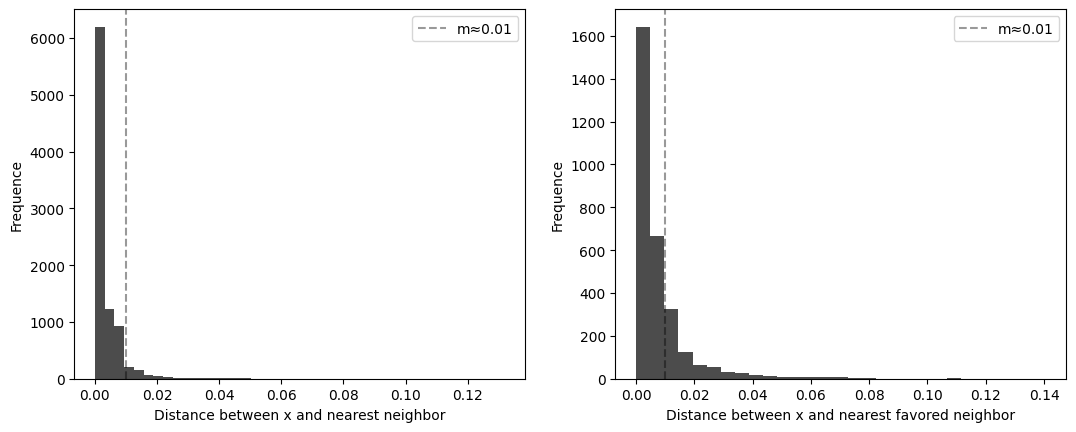

Maximum distance: 0.13
Centers of the two 'modes': 0.0, 0.01



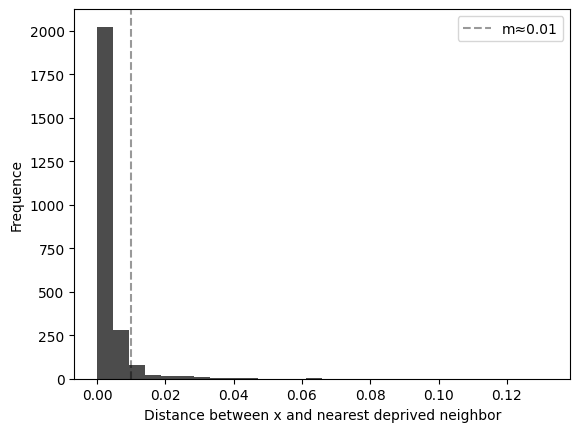

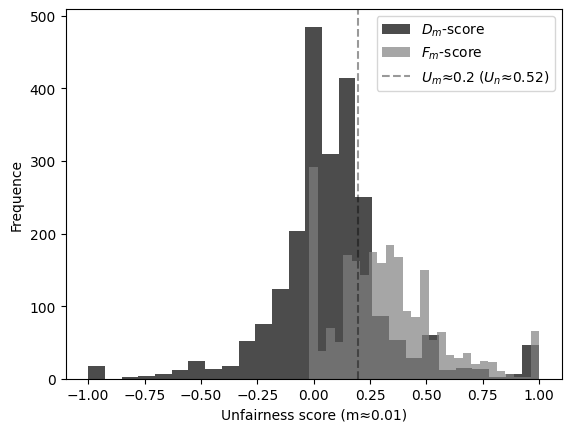

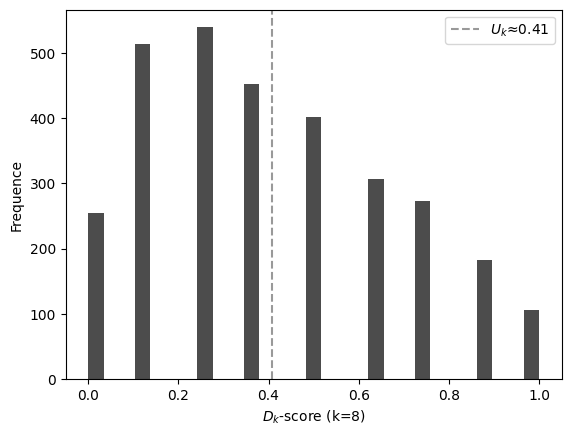

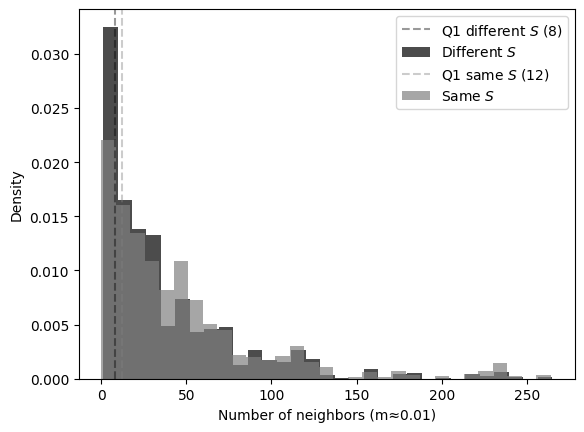

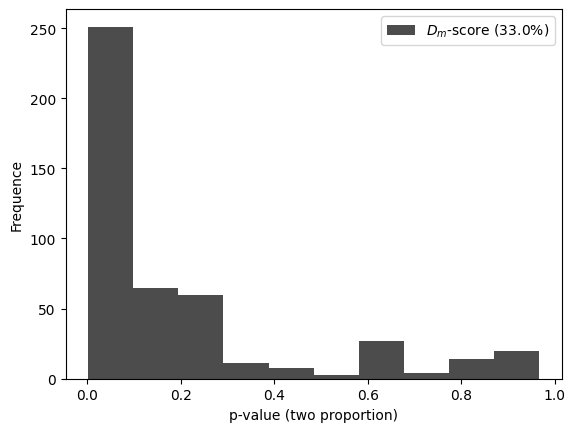

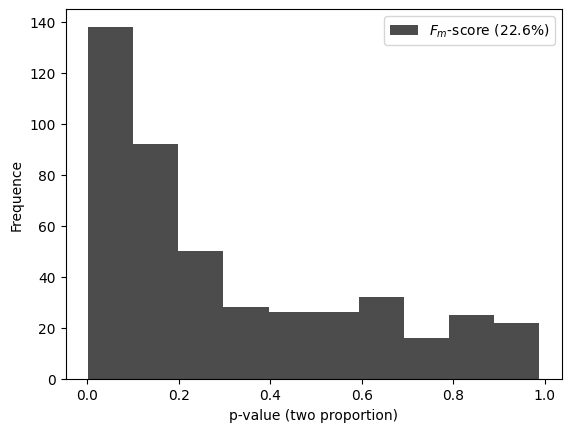

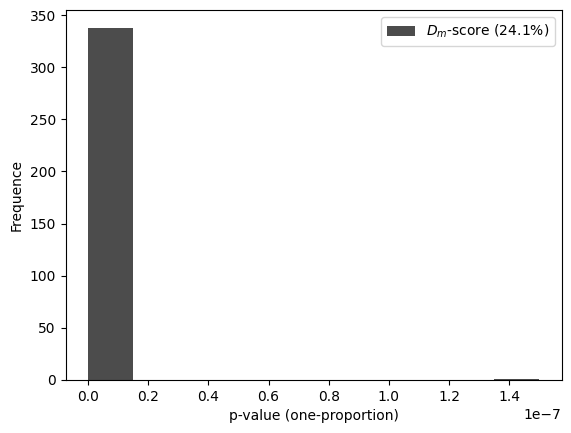

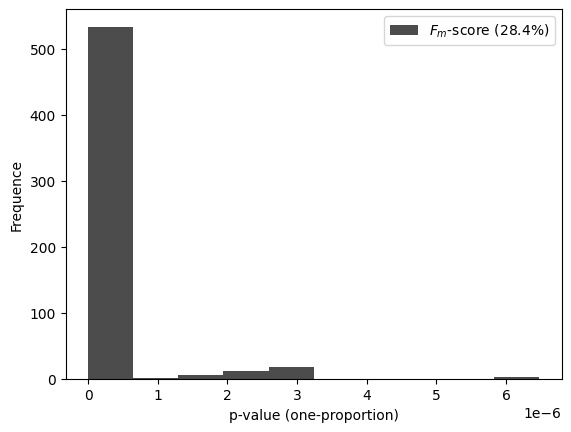

In [56]:
# w_compas = get_w(df_compas, bin_cols_compas, nom_cols_compas, int_cols_compas, ord_cols_compas, 'compas', save=1)
w_compas = pd.read_excel(f'{w_path}w_compas_8946_0.09.xlsx', usecols=['w']).to_numpy()
# df_compas = df_compas_original.sample(frac=0.1, random_state=state).reset_index(drop=True)
d_matrix_compas = get_d_matrix(df_compas, w_compas[0], bin_cols_compas, nom_cols_compas, int_cols_compas, ord_cols_compas)
m_compas = get_m(df_compas.to_numpy(), d_matrix_compas, 'compas')
_, _, _, _ = get_unfair_instances(df_compas.to_numpy(), d_matrix_compas, m_compas, 'compas', plot=1, save=1)


In [57]:
# d_matrix_ar = np.empty(0)
# m_ar = np.nan

Time when starting calculating d_matrix: 19:05:19
Total runtime (in minutes): 0.46
Maximum distance: 0.35
Center of largest bin: 0.1

Maximum distance: 0.26
Center of largest bin: 0.1



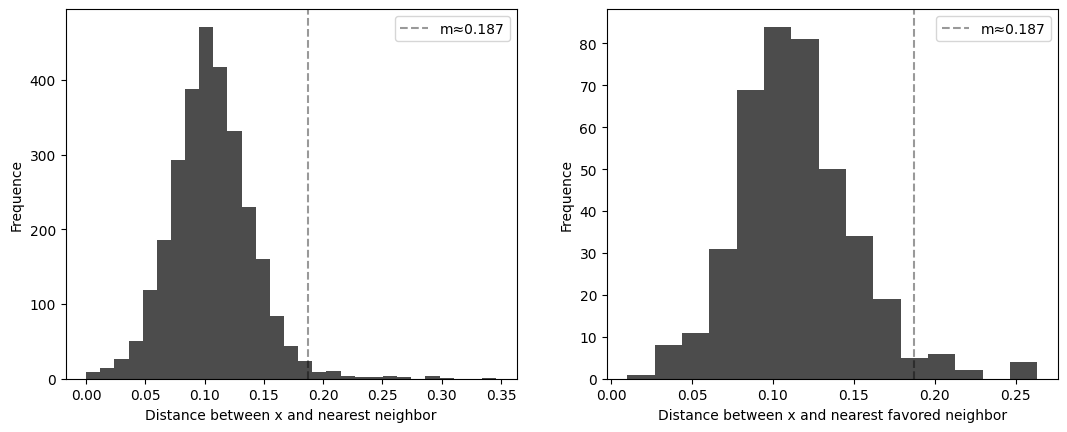

Maximum distance: 0.48
Centers of the two 'modes': 0.33, 0.11



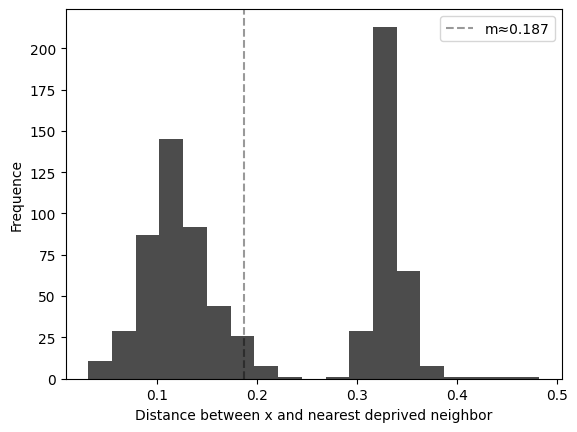

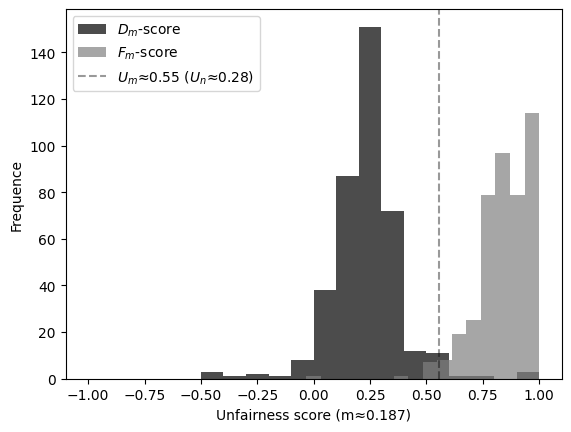

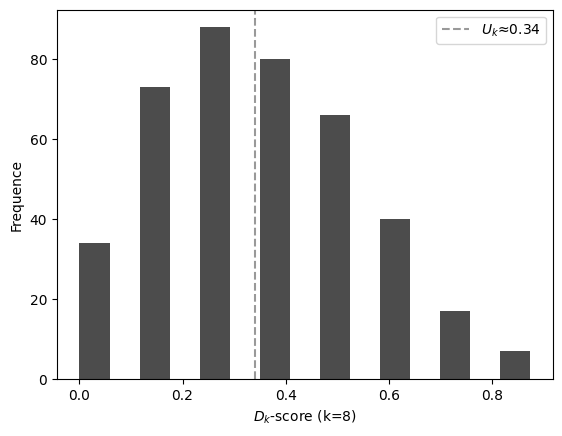

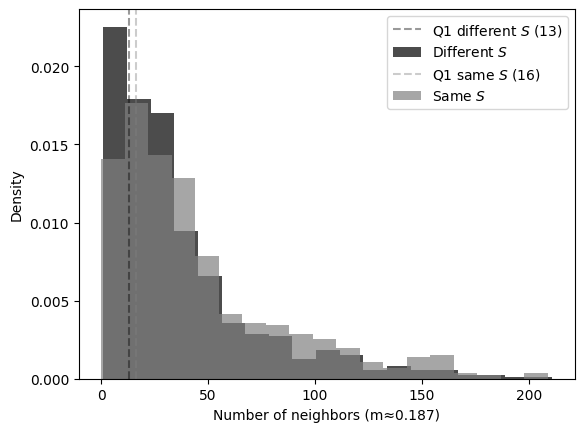

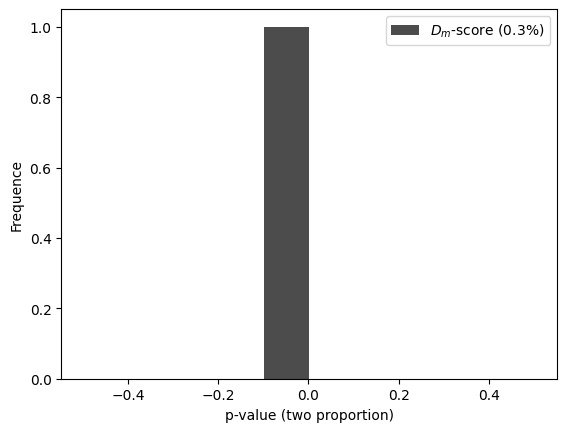

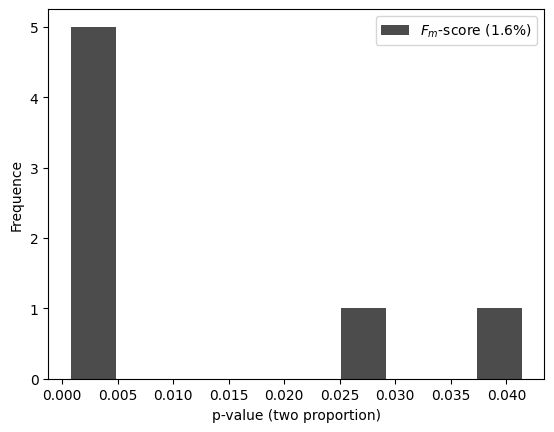

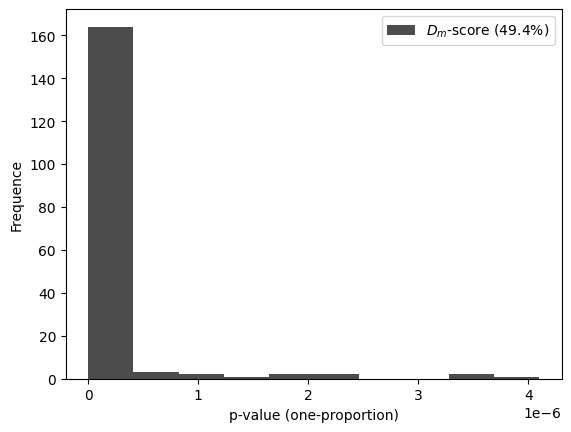


Assumptions for the one-proportion test for all favored instances are not met


In [58]:
# w_ar = get_w(df_ar, bin_cols_ar, nom_cols_ar, int_cols_ar, ord_cols_ar, 'ar', save=1)
w_ar = pd.read_excel(f'{w_path}w_ar_2887_0.09.xlsx', usecols=['w']).to_numpy()
# df_ar = df_ar_original.sample(frac=0.4, random_state=state).reset_index(drop=True)
d_matrix_ar = get_d_matrix(df_ar, w_ar[0], bin_cols_ar, nom_cols_ar, int_cols_ar, ord_cols_ar)
m_ar = get_m(df_ar.to_numpy(), d_matrix_ar, 'ar')
_, _, _, _ = get_unfair_instances(df_ar.to_numpy(), d_matrix_ar, m_ar, 'ar', plot=1, save=1)

# Load metrics

In [59]:
# [pr_nbs_adult_nan, pr_1nn_adult_nan, pr_3nn_adult_nan, pr_7nn_adult_nan, pr_dt_adult_nan,
#  pr_logit_adult_nan] = load_metrics(
#     ['pr_nbs_adult', 'pr_1nn_adult', 'pr_3nn_adult', 'pr_7nn_adult', 'pr_dt_adult', 'pr_logit_adult'],
#     'Code outputs/Metrics/Adult without U/')
# [pr_nbs_adult_u, pr_1nn_adult_u, pr_3nn_adult_u, pr_7nn_adult_u, pr_dt_adult_u, pr_logit_adult_u] = load_metrics(
#     ['pr_nbs_adult', 'pr_1nn_adult', 'pr_3nn_adult', 'pr_7nn_adult', 'pr_dt_adult', 'pr_logit_adult'],
#     'Code outputs/Metrics/Adult with U/')

# [frw_nbs_adult_nan, frw_dt_adult_nan, frw_logit_adult_nan] = load_metrics(
#     ['frw_nbs_adult', 'frw_dt_adult', 'frw_logit_adult'], 'Code outputs/Metrics/Adult without U/')
# [frw_nbs_adult_u, frw_dt_adult_u, frw_logit_adult_u] = load_metrics(
#     ['frw_nbs_adult', 'frw_dt_adult', 'frw_logit_adult'], 'Code outputs/Metrics/Adult with U/')

# [fps_nbs_adult_nan, fps_1nn_adult_nan, fps_3nn_adult_nan, fps_7nn_adult_nan, fps_dt_adult_nan,
#  fps_logit_adult_nan] = load_metrics(
#     ['fps_nbs_adult', 'fps_1nn_adult', 'fps_3nn_adult', 'fps_7nn_adult', 'fps_dt_adult', 'fps_logit_adult'],
#     'Code outputs/Metrics/Adult without U/')
# [fps_nbs_adult_u, fps_1nn_adult_u, fps_3nn_adult_u, fps_7nn_adult_u, fps_dt_adult_u, fps_logit_adult_u] = load_metrics(
#     ['fps_nbs_adult', 'fps_1nn_adult', 'fps_3nn_adult', 'fps_7nn_adult', 'fps_dt_adult', 'fps_logit_adult'],
#     'Code outputs/Metrics/Adult with U/')

# [frl_nbs_adult, frl_1nn_adult, frl_3nn_adult, frl_7nn_adult, frl_dt_adult, frl_logit_adult] = load_metrics(
#     ['frl_nbs_adult', 'frl_1nn_adult', 'frl_3nn_adult', 'frl_7nn_adult', 'frl_dt_adult', 'frl_logit_adult'],
#     'Code outputs/Metrics/Adult with U/')

# [pr_nbs_compas, pr_1nn_compas, pr_3nn_compas, pr_7nn_compas, pr_dt_compas, pr_logit_compas, pr_nbs_ar, pr_1nn_ar,
#  pr_3nn_ar, pr_7nn_ar, pr_dt_ar, pr_logit_ar] = load_metrics(
#     ['pr_nbs_compas_te', 'pr_1nn_compas_te', 'pr_3nn_compas_te', 'pr_7nn_compas_te', 'pr_dt_compas_te',
#      'pr_logit_compas_te', 'pr_nbs_ar', 'pr_1nn_ar', 'pr_3nn_ar', 'pr_7nn_ar', 'pr_dt_ar', 'pr_logit_ar'], m_path)

# [frw_nbs_compas, frw_dt_compas, frw_logit_compas, frw_nbs_ar, frw_dt_ar, frw_logit_ar] = load_metrics(
#     ['frw_nbs_compas_te', 'frw_dt_compas_te', 'frw_logit_compas_te', 'frw_nbs_ar', 'frw_dt_ar', 'frw_logit_ar'], m_path)

# [fps_nbs_compas, fps_1nn_compas, fps_3nn_compas, fps_7nn_compas, fps_dt_compas, fps_logit_compas, fps_nbs_ar,
#  fps_1nn_ar, fps_3nn_ar, fps_7nn_ar, fps_dt_ar, fps_logit_ar] = load_metrics(
#     ['fps_nbs_compas_te', 'fps_1nn_compas_te', 'fps_3nn_compas_te', 'fps_7nn_compas_te', 'fps_dt_compas_te',
#      'fps_logit_compas_te', 'fps_nbs_ar', 'fps_1nn_ar', 'fps_3nn_ar', 'fps_7nn_ar', 'fps_dt_ar', 'fps_logit_ar'],
#     m_path)

# [frl_nbs_compas, frl_1nn_compas, frl_3nn_compas, frl_7nn_compas, frl_dt_compas, frl_logit_compas, frl_nbs_ar,
#  frl_1nn_ar, frl_3nn_ar, frl_7nn_ar, frl_dt_ar, frl_logit_ar] = load_metrics(
#     ['frl_nbs_compas_te', 'frl_1nn_compas_te', 'frl_3nn_compas_te', 'frl_7nn_compas_te', 'frl_dt_compas_te',
#      'frl_logit_compas_te', 'frl_nbs_ar', 'frl_1nn_ar', 'frl_3nn_ar', 'frl_7nn_ar', 'frl_dt_ar', 'frl_logit_ar'],
#     m_path)


In [60]:
# _ = get_rl_metrics(
#     [frl_nbs_adult, frl_nbs_compas, frl_nbs_ar, frl_7nn_adult, frl_7nn_compas, frl_7nn_ar, frl_dt_adult, frl_dt_compas,
#      frl_dt_ar, frl_logit_adult, frl_logit_compas, frl_logit_ar],
#     ['NBS - Adult', 'NBS - COMPAS', 'NBS - AdviceRobo', '7-NN - Adult', '7-NN - COMPAS', '7-NN - AdviceRobo',
#      'DT - Adult', 'DT - COMPAS', 'DT - AdviceRobo', 'Logit - Adult', 'Logit - COMPAS', 'Logit - AdviceRobo'])


In [61]:
# _, _ = create_metrics_table([[[[pr_nbs_adult_nan, pr_nbs_adult_u], 'baseline', 'baseline'],
#                               [[pr_nbs_adult_nan, pr_nbs_adult_u], 0.975, 0.975],
#                               [[frw_nbs_adult_nan, frw_nbs_adult_u], 7.6, 5.2],
#                               [[fps_nbs_adult_nan, fps_nbs_adult_u], 5.9375, 4.0625], [frl_nbs_adult, 'rl', 'rl'],
#                               [frl_nbs_adult, 1, 0.4], [pr_nbs_compas, 'baseline', 'baseline'],
#                               [pr_nbs_compas, 0.9, 0.975], [frw_nbs_compas, 4.6875, 3.4375], [fps_nbs_compas, 3.25, 3],
#                               [frl_nbs_compas, 'rl', 'rl'], [frl_nbs_compas, 0.85, 1],
#                               [pr_nbs_ar, 'baseline', 'baseline'], [pr_nbs_ar, 0.575, 0.975], [frw_nbs_ar, 2.4, 5.2],
#                               [fps_nbs_ar, 1.875, 4.6875], [frl_nbs_ar, 'rl', 'rl'], [frl_nbs_ar, 0.45, 0.8]],
#                              [[[pr_7nn_adult_nan, pr_7nn_adult_u], 'baseline', 'baseline'],
#                               [[pr_7nn_adult_nan, pr_7nn_adult_u], 0.7, 0.725], [pd.DataFrame(), np.nan, np.nan],
#                               [[fps_7nn_adult_nan, fps_7nn_adult_u], 5.625, 0.3125], [frl_7nn_adult, 'rl', 'rl'],
#                               [frl_7nn_adult, 1, 0.3], [pr_7nn_compas, 'baseline', 'baseline'],
#                               [pr_7nn_compas, 0.575, 0.725], [pd.DataFrame(), np.nan, np.nan], [fps_7nn_compas, 1, 1.6],
#                               [frl_7nn_compas, 'rl', 'rl'], [frl_7nn_compas, 0.45, 0.5],
#                               [pr_7nn_ar, 'baseline', 'baseline'], [pr_7nn_ar, 0.55, 0.725],
#                               [pd.DataFrame(), np.nan, np.nan], [fps_7nn_ar, 0.56, 0.96], [frl_7nn_ar, 'rl', 'rl'],
#                               [frl_7nn_ar, 0.25, 0.55]],
#                              [[[pr_dt_adult_nan, pr_dt_adult_u], 'baseline', 'baseline'],
#                               [[pr_dt_adult_nan, pr_dt_adult_u], 0.7, 0.725],
#                               [[frw_dt_adult_nan, frw_dt_adult_u], 4.5, 0.25],
#                               [[fps_dt_adult_nan, fps_dt_adult_u], 1.8, 0.8], [frl_dt_adult, 'rl', 'rl'],
#                               [frl_dt_adult, 0.75, 0], [pr_dt_compas, 'baseline', 'baseline'],
#                               [pr_dt_compas, 0.6, 0.775], [frw_dt_compas, 2.25, 2.5], [fps_dt_compas, 1, 2],
#                               [frl_dt_compas, 'rl', 'rl'], [frl_dt_compas, 0.35, 0.6],
#                               [pr_dt_ar, 'baseline', 'baseline'], [pr_dt_ar, 0.675, 0.775], [frw_dt_ar, 2, 7.5],
#                               [fps_dt_ar, 1, 10], [frl_dt_ar, 'rl', 'rl'], [frl_dt_ar, 0.6, 0.5]],
#                              [[[pr_logit_adult_nan, pr_logit_adult_u], 'baseline', 'baseline'],
#                               [[pr_logit_adult_nan, pr_logit_adult_u], 0.7, 0.775],
#                               [[frw_logit_adult_nan, frw_logit_adult_u], 5.9375, 2.5],
#                               [[fps_logit_adult_nan, fps_logit_adult_u], 3.8, 1.8], [frl_logit_adult, 'rl', 'rl'],
#                               [frl_logit_adult, 1, 0.85], [pr_logit_compas, 'baseline', 'baseline'],
#                               [pr_logit_compas, 0.625, 0.85], [frw_logit_compas, 1.5, 2], [fps_logit_compas, 0.64, 0.8],
#                               [frl_logit_compas, 'rl', 'rl'], [frl_logit_compas, 0.25, 0.4],
#                               [pr_logit_ar, 'baseline', 'baseline'], [pr_logit_ar, 0.65, 0.775],
#                               [frw_logit_ar, 3.5, 10], [fps_logit_ar, 2, 8], [frl_logit_ar, 'rl', 'rl'],
#                               [frl_logit_ar, 0.6, 0.5]]],
#                             ['Adult - baseline', 'Adult - PR', 'Adult - FRW', 'Adult - FPS', 'Adult - RL',
#                              'Adult - FRL', 'COMPAS - baseline', 'COMPAS - PR', 'COMPAS - FRW', 'COMPAS - FPS',
#                              'COMPAS - RL', 'COMPAS - FRL', 'AdviceRobo - baseline', 'AdviceRobo - PR',
#                              'AdviceRobo - FRW', 'AdviceRobo - FPS', 'AdviceRobo - RL', 'AdviceRobo - FRL'],
#                             ['NBS', '7-NN', 'DT', 'Logit'])


In [62]:
# frl_logit_compas.style.background_gradient(cmap="RdYlGn")

# Probabilistic Rejection

In [63]:
def post_proces(clf, clf_name, df, df_name, cat_cols, nom_cols, thetas=None, test=True, d_matrix=np.empty(0), m=np.nan,
                n_bins=[10], drop_s=False, print_metrics=True, export=True, no_print=False):
    """
        Applies PR on validation/test predictions

        :param clf: instance of classifier (use clf=None for NBS)
        :param clf_name: name of classifier
        :param df: dataframe (column 0 = class_label (positive decision = 1),
        column 1 = sensitive attribute (deprived group = 1), column 2 = explanatory attribute)
        :param df_name: name of dataset
        :param cat_cols: list with column names of categorical attributes in df (needed for NBS)
        :param nom_cols: list with column names of nominal attributes in df (needed for one-hot-encoding)
        :param thetas: list with theta parameters to tune accuracy-fairness (default=None)
        :param test: whether to make predictions for the test or validation set (default=False)
        :param d_matrix: ndarray with distance matrix for measuring individual unfairness U (default=np.empty(0))
        :param m: m for measuring individual unfairness U using m-NN (default=np.nan)
        :param n_bins: number of bins used to discretize the explanatory attribute
        :param drop_s: whether to drop the sensitive attribute for training/prediction or not (default=False)
        :param print_metrics: print dataframe with metrics (default=True)
        :param export: whether to export the metrics (default=True)
        :param no_print: whether to not print anything or print everything (default=False,
        =True when tuning hyperparameters for DT)
        :return: dataframe with metrics
    """

    if clf_name == 'knn':
        save_name = str(clf.get_params()['n_neighbors']) + clf_name[1:] + '_' + df_name
    else:
        save_name = clf_name + '_' + df_name
    if not no_print:
        print(' ' * 50 + clf_name + ' - ' + df_name)
    if export:
        if not test:
            pd.DataFrame().to_excel(f'{m_path}pr_{save_name}_val.xlsx')
        else:
            pd.DataFrame().to_excel(f'{m_path}pr_{save_name}_te.xlsx')

    y_pr_val, y_pr_te = train(clf, clf_name, df, cat_cols, nom_cols, test=test, drop_s=drop_s, no_print=no_print)

    if not test:
        y_pr = y_pr_val
    else:
        y_pr = y_pr_te
    y_pr['1_min_p'] = 1 - y_pr['y_prob']
    y_pr['max'] = y_pr[['y_prob', '1_min_p']].max(axis=1)
    y_pr['baseline'] = y_pr['y_prob']
    for theta in thetas:
        # Rounding down
        y_pr[theta] = (y_pr['y_prob'] > 0.5).astype(int)
        y_pr.loc[(y_pr['max'] <= theta) & (y_pr[theta] == 1) & (y_pr['s'] == 0), theta] = 0
        y_pr.loc[(y_pr['max'] <= theta) & (y_pr[theta] == 0) & (y_pr['s'] == 1), theta] = 1
    metrics_df = get_metrics(y_pr.drop(['y_prob', '1_min_p', 'max'], axis=1), df, d_matrix, m, df_name,
                             cat_cols, n_bins=n_bins)

    if export:
        if not test:
            metrics_df.to_excel(f'{m_path}pr_{save_name}_val.xlsx')
        else:
            metrics_df.to_excel(f'{m_path}pr_{save_name}_te.xlsx')
    if print_metrics:
        print(metrics_df)
    if not no_print:
        print('-' * 100)

    return metrics_df


In [64]:
# This DT classifier is used for all datasets/techniques
# df_adult with instances 48842 instances
dt_clf = DecisionTreeClassifier(random_state=state, min_samples_leaf=0.02)
# df_adult with 1131 instances
# dt_clf = DecisionTreeClassifier(random_state=state, min_samples_split=0.26)

In [65]:
pr_thetas = np.round(np.arange(0.525, 1, 0.025), 4).tolist()

# pr_nbs_adult = post_proces(None, 'nbs', df_adult, 'adult', cat_cols_adult, nom_cols_adult, pr_thetas)
# pr_1nn_adult = post_proces(KNeighborsClassifier(n_neighbors=1), 'knn', df_adult, 'adult', cat_cols_adult,
#                            nom_cols_adult, pr_thetas)
# pr_3nn_adult = post_proces(KNeighborsClassifier(n_neighbors=3), 'knn', df_adult, 'adult', cat_cols_adult,
#                            nom_cols_adult, pr_thetas)
# pr_7nn_adult = post_proces(KNeighborsClassifier(n_neighbors=7), 'knn', df_adult, 'adult', cat_cols_adult,
#                            nom_cols_adult, pr_thetas)
# pr_dt_adult = post_proces(dt_clf, 'dt', df_adult, 'adult', cat_cols_adult, nom_cols_adult, pr_thetas)
# pr_logit_adult = post_proces(LogisticRegression(random_state=state, max_iter=3000), 'logit', df_adult, 'adult',
#                              cat_cols_adult, nom_cols_adult, pr_thetas)

# pr_nbs_compas = post_proces(None, 'nbs', df_compas, 'compas', cat_cols_compas, nom_cols_compas, pr_thetas, n_bins=[6])
# pr_1nn_compas = post_proces(KNeighborsClassifier(n_neighbors=1), 'knn', df_compas, 'compas', cat_cols_compas,
#                             nom_cols_compas, pr_thetas, n_bins=[6])
# pr_3nn_compas = post_proces(KNeighborsClassifier(n_neighbors=3), 'knn', df_compas, 'compas', cat_cols_compas,
#                             nom_cols_compas, pr_thetas, n_bins=[6])
# pr_7nn_compas = post_proces(KNeighborsClassifier(n_neighbors=7), 'knn', df_compas, 'compas', cat_cols_compas,
#                             nom_cols_compas, pr_thetas, n_bins=[6])
# pr_dt_compas = post_proces(dt_clf, 'dt', df_compas, 'compas', cat_cols_compas, nom_cols_compas, pr_thetas, n_bins=[6])
# pr_logit_compas = post_proces(LogisticRegression(random_state=state, max_iter=1000), 'logit', df_compas, 'compas',
#                               cat_cols_compas, nom_cols_compas, pr_thetas, n_bins=[6])

# pr_nbs_ar = post_proces(None, 'nbs', df_ar, 'ar', cat_cols_ar, nom_cols_ar, pr_thetas)
# # Hard to remove D_u for all k-NN clfs for AR dataset, since there's not much D_u left in their predictions
# pr_1nn_ar = post_proces(KNeighborsClassifier(n_neighbors=1), 'knn', df_ar, 'ar', cat_cols_ar, nom_cols_ar, pr_thetas)
# pr_3nn_ar = post_proces(KNeighborsClassifier(n_neighbors=3), 'knn', df_ar, 'ar', cat_cols_ar, nom_cols_ar, pr_thetas)
# pr_7nn_ar = post_proces(KNeighborsClassifier(n_neighbors=7), 'knn', df_ar, 'ar', cat_cols_ar, nom_cols_ar, pr_thetas)
# pr_dt_ar = post_proces(dt_clf, 'dt', df_ar, 'ar', cat_cols_ar, nom_cols_ar, pr_thetas)
# pr_logit_ar = post_proces(LogisticRegression(random_state=state, max_iter=1000), 'logit', df_ar, 'ar', cat_cols_ar,
#                           nom_cols_ar, pr_thetas)


# Fair Reweighing

In [66]:
def reweight(clf, clf_name, df, df_name, cat_cols, nom_cols, gammas=None, test=True, d_matrix=np.empty(0), m=np.nan,
             n_bins=[10], drop_s=False, print_weights=False, print_metrics=True, export=True, no_print=False):
    """
        Applies FRW on training set

        :param clf: instance of classifier (use clf=None for NBS)
        :param clf_name: name of classifier
        :param df: dataframe (column 0 = class_label (positive decision = 1),
        column 1 = sensitive attribute (deprived group = 1), column 2 = explanatory attribute)
        :param df_name: name of dataset
        :param cat_cols: list with column names of categorical attributes in df (needed for NBS)
        :param nom_cols: list with column names of nominal attributes in df (needed for one-hot-encoding)
        :param gammas: list with gamma parameters to tune accuracy-fairness (default=None)
        :param test: whether to make predictions for the test or validation set (default=False)
        :param d_matrix: ndarray with distance matrix for measuring individual unfairness U (default=np.empty(0))
        :param m: m for measuring individual unfairness U using m-NN (default=np.nan)
        :param n_bins: number of bins used to discretize the explanatory attribute (default=10)
        :param drop_s: whether to drop the sensitive attribute for training/prediction or not (default=False)
        :param print_weights: print percentage of weigthed instances and weigths (default=False)
        :param print_metrics: print dataframe with metrics (default=True)
        :param export: whether to export the metrics (default=True)
        :param no_print: whether to not print anything or print everything (default=False,
        =True when tuning hyperparameters for DT)
        :return: dataframe with metrics
    """

    save_name = clf_name + '_' + df_name
    if not no_print:
        print(' ' * 50 + clf_name + ' - ' + df_name)
    if export:
        if not test:
            pd.DataFrame().to_excel(f'{m_path}frw_{save_name}_val.xlsx')
        else:
            pd.DataFrame().to_excel(f'{m_path}frw_{save_name}_te.xlsx')

    y_pr_val_0, y_pr_te_0 = train(clf, clf_name, df, cat_cols, nom_cols, test=test, drop_s=drop_s, no_print=no_print)
    if not test:
        fnr_d, fpr_d, fnr_f, fpr_f, d_ix, f_ix = get_misclassification_metrics(y_pr_val_0)
    else:
        fnr_d, fpr_d, fnr_f, fpr_f, d_ix, f_ix = get_misclassification_metrics(y_pr_te_0)

    if print_weights:
        d_fn_percentage = (d_ix.shape[0] / df.shape[0]) * 100
        f_fp_percentage = (f_ix.shape[0] / df.shape[0]) * 100
        print(f'Weighted X^d: {round(d_fn_percentage, 2)}%')
        print(f'Weighted X^f: {round(f_fp_percentage, 2)}%')
        print(f'Weights (γ=1) for X^d: {round(fnr_d / fnr_f, 2)}')
        print(f'Weights (γ=1) for X^f: {round(fpr_d / fpr_f, 2)}')
        print()

    gammas.insert(0, 'baseline')
    sample_weights = [gammas, np.ones(df.shape[0])]
    for gamma in gammas[1:]:
        w_d = gamma * fnr_d / fnr_f
        w_f = gamma * fpr_d / fpr_f

        sample_weight = np.ones(df.shape[0])
        sample_weight[d_ix] = w_d
        sample_weight[f_ix] = w_f

        sample_weights.append(sample_weight)

    y_pr_val_1, y_pr_te_1 = train(clf, clf_name, df, cat_cols, nom_cols, 'frw', sample_weights, test, drop_s, no_print)

    if not test:
        metrics_df = get_metrics(y_pr_val_1, df, d_matrix, m, df_name, cat_cols, n_bins=n_bins)
    else:
        metrics_df = get_metrics(y_pr_te_1, df, d_matrix, m, df_name, cat_cols, n_bins=n_bins)

    if export:
        if not test:
            metrics_df.to_excel(f'{m_path}frw_{save_name}_val.xlsx')
        else:
            metrics_df.to_excel(f'{m_path}frw_{save_name}_te.xlsx')
    if print_metrics:
        print(metrics_df)
    if not no_print:
        print('-' * 100)

    return metrics_df


In [67]:
# start = 0
# stop = 0.1
# step = (stop - start) / 20

# param_values = np.round(np.arange(start+step, stop+step, step), 10).tolist()
# param_values = [0.02]
# # param_values = [int(x) for x in (np.arange(start+step, stop+step, step)).tolist()]
# # param_values = [46]
# # print(len(param_values))
# print(param_values)

In [68]:
# for p in param_values:
#     model = DecisionTreeClassifier(random_state=state, min_samples_leaf=p)
#     pr_dt_ar = post_proces(model, 'dt', df_ar, 'ar', cat_cols_ar, nom_cols_ar, pr_thetas, test=0, print_metrics=0,
#                            export=0, no_print=1)
#     pr_dt_adult = post_proces(dt_clf, 'dt', df_adult, 'adult', cat_cols_adult, nom_cols_adult, pr_thetas, test=0,
#                               print_metrics=0, export=0, no_print=1)
#     frw_dt_ar = reweight(model, 'dt', df_ar, 'ar', cat_cols_ar, nom_cols_ar, [g / 1.6 for g in [*range(1, 21, 1)]],
#                          test=0, print_metrics=0, export=0, no_print=1)
#     frw_dt_adult = reweight(model, 'dt', df_adult, 'adult', cat_cols_adult, nom_cols_adult,
#                             [g / 3.2 for g in [*range(1, 21, 1)]], test=0, print_metrics=0, export=0, no_print=1)
#     print(f'param_value={p}')
#     plot_metrics([[[pr_dt_ar, pr_dt_adult, frw_dt_ar, frw_dt_adult], ['PR_ar', 'PR_adult', 'FRW_ar', 'FRW_adult'], 4]],
#                  'test', 1, save=0,
#                  no_print=1)
# Beep(600, 1500)


In [69]:
# frw_nbs_adult = reweight(None, 'nbs', df_adult, 'adult', cat_cols_adult, nom_cols_adult,
#                          [g / 2.5 for g in [*range(1, 21, 1)]])
# frw_dt_adult = reweight(dt_clf, 'dt', df_adult, 'adult', cat_cols_adult, nom_cols_adult,
#                         [g / 3.2 for g in [*range(1, 21, 1)]])
# frw_logit_adult = reweight(LogisticRegression(random_state=state, max_iter=5000), 'logit', df_adult, 'adult',
#                            cat_cols_adult, nom_cols_adult, [g / 3.2 for g in [*range(1, 21, 1)]])

# frw_nbs_compas = reweight(None, 'nbs', df_compas, 'compas', cat_cols_compas, nom_cols_compas,
#                           [g / 3.2 for g in [*range(1, 21, 1)]], n_bins=[6])
# frw_dt_compas = reweight(dt_clf, 'dt', df_compas, 'compas', cat_cols_compas, nom_cols_compas,
#                          [g / 8 for g in [*range(1, 21, 1)]], n_bins=[6])
# frw_logit_compas = reweight(LogisticRegression(random_state=state, max_iter=1000), 'logit', df_compas, 'compas',
#                             cat_cols_compas, nom_cols_compas, [g / 10 for g in [*range(1, 21, 1)]], n_bins=[6])

# frw_nbs_ar = reweight(None, 'nbs', df_ar, 'ar', cat_cols_ar, nom_cols_ar, [g / 2.5 for g in [*range(1, 21, 1)]])
# frw_dt_ar = reweight(dt_clf, 'dt', df_ar, 'ar', cat_cols_ar, nom_cols_ar, [g / 2 for g in [*range(1, 21, 1)]])
# frw_logit_ar = reweight(LogisticRegression(random_state=state, max_iter=2000), 'logit', df_ar, 'ar', cat_cols_ar,
#                         nom_cols_ar, [g / 2 for g in [*range(1, 21, 1)]])


# Fair Preferential Sampling

In [70]:
def sample(clf, clf_name, df, df_name, cat_cols, nom_cols, betas, test=True, d_matrix=np.empty(0), m=np.nan,
           n_bins=[10], drop_s=False, print_repeats=False, print_metrics=True, export=True, no_print=False):
    """
        Applies FPS on training set

        :param clf: instance of classifier (use clf=None for NBS)
        :param clf_name: name of classifier
        :param df: dataframe (column 0 = class_label (positive decision = 1),
        column 1 = sensitive attribute (deprived group = 1), column 2 = explanatory attribute)
        :param df_name: name of dataset
        :param cat_cols: list with column names of categorical attributes in df (needed for NBS)
        :param nom_cols: list with column names of nominal attributes in df (needed for one-hot-encoding)
        :param betas: list with beta parameters to tune accuracy-fairness (default=None)
        :param test: whether to make predictions for the test or validation set (default=False)
        :param d_matrix: ndarray with distance matrix for measuring individual unfairness U (default=np.empty(0))
        :param m: m for measuring individual unfairness U using m-NN (default=np.nan)
        :param n_bins: number of bins used to discretize the explanatory attribute (default=10)
        :param drop_s: whether to drop the sensitive attribute for training/prediction or not (default=False)
        :param print_repeats: print percentage of sampled instances and repeats (default=False)
        :param print_metrics: print dataframe with metrics (default=True)
        :param export: whether to export the metrics (default=True)
        :param no_print: whether to not print anything or print everything (default=False,
        =True when tuning hyperparameters for DT)
        :return: dataframe with metrics, where the indices are the different parameter values
    """

    if clf_name == 'knn':
        save_name = str(clf.get_params()['n_neighbors']) + clf_name[1:] + '_' + df_name
    else:
        save_name = clf_name + '_' + df_name
    if not no_print:
        print(' ' * 50 + clf_name + ' - ' + df_name)
    if export:
        if not test:
            pd.DataFrame().to_excel(f'{m_path}fps_{save_name}_val.xlsx')
        else:
            pd.DataFrame().to_excel(f'{m_path}fps_{save_name}_te.xlsx')

    y_pr_val_0, y_pr_te_0 = train(clf, clf_name, df, cat_cols, nom_cols, test=test, drop_s=drop_s, no_print=no_print)

    if not test:
        fnr_d, fpr_d, fnr_f, fpr_f, d_ix, f_ix = get_misclassification_metrics(y_pr_val_0)
    else:
        fnr_d, fpr_d, fnr_f, fpr_f, d_ix, f_ix = get_misclassification_metrics(y_pr_te_0)

    if print_repeats:
        d_fn_percentage = (d_ix.shape[0] / df.shape[0]) * 100
        f_fp_percentage = (f_ix.shape[0] / df.shape[0]) * 100
        print(f'X^d oversampled: {round(d_fn_percentage, 2)}%')
        print(f'X^f oversampled: {round(f_fp_percentage, 2)}%')
        print(f'#Oversampled (β=1) for X^d: {floor(len(d_ix) * fnr_d / fnr_f)}')
        print(f'#Oversampled (β=1) for X^f: {floor(len(f_ix) * fpr_d / fpr_f)}')
        print()

    # k-NN/DT/logit cannot work with nominal attributes!
    if clf_name == 'knn' or clf_name == 'dt':
        df_enc = pd.get_dummies(df, columns=nom_cols.copy())
    elif clf_name == 'logit':
        df_enc = pd.get_dummies(df, columns=nom_cols.copy(), drop_first=True)
    else:
        df_enc = df.copy()

    if drop_s:
        df_enc = df_enc.drop(df_enc.columns[1], axis=1)

    # First list item are beta parameters, list items after are dataframes for each beta 
    # (first dataframe is without sampling)
    betas.insert(0, 'baseline')
    dataframes = [betas, df_enc.copy()]

    for beta in betas[1:]:
        df_enc['ix'] = df_enc.index
        repeats_d = ceil(beta * fnr_d / fnr_f)
        repeats_f = ceil(beta * fpr_d / fpr_f)
        # Rounded up #instances (ceil) is removed, so rounded down (floor) #instances stay
        remove_d = ceil((repeats_d - (beta * fnr_d / fnr_f)) * len(d_ix))
        remove_f = ceil((repeats_f - (beta * fpr_d / fpr_f)) * len(f_ix))

        df_d_sampled = pd.DataFrame(np.repeat(df_enc.loc[d_ix].values, repeats_d, axis=0),
                                    columns=list(df_enc.columns))
        df_f_sampled = pd.DataFrame(np.repeat(df_enc.loc[f_ix].values, repeats_f, axis=0),
                                    columns=list(df_enc.columns))

        df_d_sampled = df_d_sampled.iloc[:-remove_d]
        df_f_sampled = df_f_sampled.iloc[:-remove_f]

        df_new = pd.concat([df_enc.copy(), df_d_sampled.copy(), df_f_sampled.copy()])
        df_new = df_new.set_index('ix')

        dataframes.append(df_new)

    y_pr_val_1, y_pr_te_1 = train(clf, clf_name, df, cat_cols, nom_cols, 'fps', dataframes, test, drop_s, no_print)

    if not test:
        metrics_df = get_metrics(y_pr_val_1, df, d_matrix, m, df_name, cat_cols, n_bins=n_bins)
    else:
        metrics_df = get_metrics(y_pr_te_1, df, d_matrix, m, df_name, cat_cols, n_bins=n_bins)

    if export:
        if not test:
            metrics_df.to_excel(f'{m_path}fps_{save_name}_val.xlsx')
        else:
            metrics_df.to_excel(f'{m_path}fps_{save_name}_te.xlsx')
    if print_metrics:
        print(metrics_df)
    if not no_print:
        print('-' * 100)

    return metrics_df


In [71]:
# fps_nbs_adult = sample(None, 'nbs', df_adult, 'adult', cat_cols_adult, nom_cols_adult,
#                        [b / 3.2 for b in [*range(0, 21, 1)]])
# fps_1nn_adult = sample(KNeighborsClassifier(n_neighbors=1), 'knn', df_adult, 'adult', cat_cols_adult, nom_cols_adult,
#                        [b / 2.5 for b in [*range(0, 21, 1)]])
# fps_3nn_adult = sample(KNeighborsClassifier(n_neighbors=3), 'knn', df_adult, 'adult', cat_cols_adult, nom_cols_adult,
#                        [b * 2.5 for b in [*range(0, 21, 1)]])
# fps_7nn_adult = sample(KNeighborsClassifier(n_neighbors=7), 'knn', df_adult, 'adult', cat_cols_adult, nom_cols_adult,
#                        [b / 3.2 for b in [*range(0, 21, 1)]])
# fps_dt_adult = sample(dt_clf, 'dt', df_adult, 'adult', cat_cols_adult, nom_cols_adult,
#                       [b / 5 for b in [*range(0, 21, 1)]])
# fps_logit_adult = sample(LogisticRegression(random_state=state, max_iter=5000), 'logit', df_adult, 'adult',
#                          cat_cols_adult, nom_cols_adult, [b / 5 for b in [*range(0, 21, 1)]])

# fps_nbs_compas = sample(None, 'nbs', df_compas, 'compas', cat_cols_compas, nom_cols_compas,
#                         [b / 4 for b in [*range(0, 21, 1)]], n_bins=[6])
# fps_1nn_compas = sample(KNeighborsClassifier(n_neighbors=1), 'knn', df_compas, 'compas', cat_cols_compas,
#                         nom_cols_compas, [b / 1 for b in [*range(0, 21, 1)]], n_bins=[6])
# fps_3nn_compas = sample(KNeighborsClassifier(n_neighbors=3), 'knn', df_compas, 'compas', cat_cols_compas,
#                         nom_cols_compas, [b / 5 for b in [*range(0, 21, 1)]], n_bins=[6])
# fps_7nn_compas = sample(KNeighborsClassifier(n_neighbors=7), 'knn', df_compas, 'compas', cat_cols_compas,
#                         nom_cols_compas, [b / 5 for b in [*range(0, 21, 1)]], n_bins=[6])
# fps_dt_compas = sample(dt_clf, 'dt', df_compas, 'compas', cat_cols_compas, nom_cols_compas,
#                        [b / 10 for b in [*range(0, 21, 1)]], n_bins=[6])
# fps_logit_compas = sample(LogisticRegression(random_state=state, max_iter=1000), 'logit', df_compas, 'compas',
#                           cat_cols_compas, nom_cols_compas, [b / 25 for b in [*range(0, 21, 1)]], n_bins=[6])

# fps_nbs_ar = sample(None, 'nbs', df_ar, 'ar', cat_cols_ar, nom_cols_ar, [b / 3.2 for b in [*range(0, 21, 1)]])
# fps_1nn_ar = sample(KNeighborsClassifier(n_neighbors=1), 'knn', df_ar, 'ar', cat_cols_ar, nom_cols_ar,
#                     [b / 5 for b in [*range(0, 21, 1)]])
# fps_3nn_ar = sample(KNeighborsClassifier(n_neighbors=3), 'knn', df_ar, 'ar', cat_cols_ar, nom_cols_ar,
#                     [b / 8 for b in [*range(0, 21, 1)]])
# fps_7nn_ar = sample(KNeighborsClassifier(n_neighbors=7), 'knn', df_ar, 'ar', cat_cols_ar, nom_cols_ar,
#                     [b / 12.5 for b in [*range(0, 21, 1)]])
# fps_dt_ar = sample(dt_clf, 'dt', df_ar, 'ar', cat_cols_ar, nom_cols_ar, [b / 2 for b in [*range(0, 21, 1)]])
# fps_logit_ar = sample(LogisticRegression(random_state=state, max_iter=2000), 'logit', df_ar, 'ar', cat_cols_ar,
#                       nom_cols_ar, [b / 2.5 for b in [*range(0, 21, 1)]])


# Fair Relabeling

In [72]:
def relabel(clf, clf_name, df, df_name, d_matrix, m, cat_cols, nom_cols, mus, test=True, n_bins=[10], t=0,
            drop_s=False, print_metrics=True, export=True):
    """
        Applies FRL on training set

        :param clf: instance of classifier (use clf=None for NBS)
        :param clf_name: name of classifier
        :param df: dataframe (column 0 = class_label (positive decision = 1),
        column 1 = sensitive attribute (deprived group = 1), column 2 = explanatory attribute)
        :param df_name: name of dataset in df
        :param d_matrix: ndarray with distance matrix
        :param m: m for measuring individual unfairness U
        :param cat_cols: list with column names of categorical attributes in df (needed for NBS)
        :param nom_cols: list with column names of nominal attributes in df (needed for one-hot-encoding)
        :param mus: list with mu parameters to tune accuracy-fairness
        :param test: whether to make predictions for the test or validation set (default=False)
        :param n_bins: number of bins used to discretize the explanatory attribute (default=10)
        :param t: unfairness threshold for (score > t ⇒ unfair, default=0)
        :param drop_s: whether to drop the sensitive attribute for training/prediction or not (default=False)
        :param print_metrics: print dataframe with metrics (default=True)
        :param export: whether to export the metrics (default=True)
        :return: dataframe with metrics
    """

    if clf_name == 'knn':
        save_name = str(clf.get_params()['n_neighbors']) + clf_name[1:] + '_' + df_name
    else:
        save_name = clf_name + '_' + df_name
    print(' ' * 50 + clf_name + ' - ' + df_name)
    if export:
        if not test:
            pd.DataFrame().to_excel(f'{m_path}frl_{save_name}_val.xlsx')
        else:
            pd.DataFrame().to_excel(f'{m_path}frl_{save_name}_te.xlsx')

    u_d, u_f, _, _ = get_unfair_instances(df.to_numpy(), d_matrix, m, df_name, t=t)

    # DT/k-NN/logit cannot work with nominal attributes
    if clf_name == 'dt' or clf_name == 'knn':
        df_enc = pd.get_dummies(df, columns=nom_cols)
    elif clf_name == 'logit':
        df_enc = pd.get_dummies(df, columns=nom_cols, drop_first=True)
    else:
        df_enc = df.copy()

    dfs_frl = []
    mus_copy = mus.copy()
    mus_copy.insert(0, 'baseline')
    mus_copy.insert(1, 'rl')
    dfs_frl.append(mus_copy)

    dfs_frl.append(df_enc)
    df_rl = df_enc.copy()
    # RL (Luong et al., 2011)
    df_rl.iloc[u_d[:, 0].astype(int), 0] = 1
    dfs_frl.append(df_rl)

    # Add column for sensitive attribute
    u_d = np.hstack((u_d, np.ones((len(u_d), 1))))
    u_f = np.hstack((u_f, np.zeros((len(u_f), 1))))
    u = np.vstack((u_d, u_f))
    # Columns indices of u: 0=index , 1=unfairness score, 2=# instances different S, 3=# instances same S, 
    # 6=sensitive attribute, sort on #instances first then sort on unfairness score
    u = u[np.lexsort((-u[:, 3], -u[:, 2], -u[:, 1]))]

    # FRL for different mu values
    for mu in mus:
        df_frl = df_enc.copy()
        n_u = round(u.shape[0] * mu)
        u_01 = u[:n_u, :]

        for i, row in enumerate(u_01):
            if u_01[i, 6] == 1:
                df_frl.iloc[u_01[i, 0].astype(int), 0] = 1
            else:
                df_frl.iloc[u_01[i, 0].astype(int), 0] = 0

        dfs_frl.append(df_frl)

    y_pr_val, y_pr_te = train(clf, clf_name, df, cat_cols, nom_cols, 'frl', dfs_frl, test, drop_s=drop_s)

    if not test:
        metrics_df = get_metrics(y_pr_val, df, d_matrix, m, df_name, cat_cols, n_bins, t)
    else:
        metrics_df = get_metrics(y_pr_te, df, d_matrix, m, df_name, cat_cols, n_bins, t)

    if export:
        if not test:
            metrics_df.to_excel(f'{m_path}frl_{save_name}_val.xlsx')
        else:
            metrics_df.to_excel(f'{m_path}frl_{save_name}_te.xlsx')
    if print_metrics:
        print(metrics_df)
    print('-' * 100)

    return metrics_df


In [73]:
frl_mus = [m / 20 for m in [*range(0, 21, 1)]]

# frl_nbs_adult = relabel(None, 'nbs', df_adult, 'adult', d_matrix_adult, m_adult, cat_cols_adult, nom_cols_adult,
#                         frl_mus)
# frl_1nn_adult = relabel(KNeighborsClassifier(n_neighbors=1), 'knn', df_adult, 'adult', d_matrix_adult, m_adult,
#                         cat_cols_adult, nom_cols_adult, frl_mus)
# frl_3nn_adult = relabel(KNeighborsClassifier(n_neighbors=3), 'knn', df_adult, 'adult', d_matrix_adult, m_adult,
#                         cat_cols_adult, nom_cols_adult, frl_mus)
# frl_7nn_adult = relabel(KNeighborsClassifier(n_neighbors=7), 'knn', df_adult, 'adult', d_matrix_adult, m_adult,
#                         cat_cols_adult, nom_cols_adult, frl_mus)
# frl_dt_adult = relabel(dt_clf, 'dt', df_adult, 'adult', d_matrix_adult, m_adult, cat_cols_adult, nom_cols_adult,
#                        frl_mus)
# frl_logit_adult = relabel(LogisticRegression(random_state=state, max_iter=5000), 'logit', df_adult, 'adult',
#                           d_matrix_adult, m_adult, cat_cols_adult, nom_cols_adult, frl_mus)

# frl_nbs_compas = relabel(None, 'nbs', df_compas, 'compas', d_matrix_compas, m_compas, cat_cols_compas, nom_cols_compas,
#                          frl_mus, n_bins=[6])
# frl_1nn_compas = relabel(KNeighborsClassifier(n_neighbors=1), 'knn', df_compas, 'compas', d_matrix_compas, m_compas,
#                          cat_cols_compas, nom_cols_compas, frl_mus, n_bins=[6])
# frl_3nn_compas = relabel(KNeighborsClassifier(n_neighbors=3), 'knn', df_compas, 'compas', d_matrix_compas, m_compas,
#                          cat_cols_compas, nom_cols_compas, frl_mus, n_bins=[6])
# frl_7nn_compas = relabel(KNeighborsClassifier(n_neighbors=7), 'knn', df_compas, 'compas', d_matrix_compas, m_compas,
#                          cat_cols_compas, nom_cols_compas, frl_mus, n_bins=[6])
# frl_dt_compas = relabel(dt_clf, 'dt', df_compas, 'compas', d_matrix_compas, m_compas, cat_cols_compas, nom_cols_compas,
#                         frl_mus, n_bins=[6])
# frl_logit_compas = relabel(LogisticRegression(random_state=state, max_iter=1000), 'logit', df_compas, 'compas',
#                            d_matrix_compas, m_compas, cat_cols_compas, nom_cols_compas, frl_mus, n_bins=[6])

# frl_nbs_ar = relabel(None, 'nbs', df_ar, 'ar', d_matrix_ar, m_ar, cat_cols_ar, nom_cols_ar, frl_mus)
# frl_1nn_ar = relabel(KNeighborsClassifier(n_neighbors=1), 'knn', df_ar, 'ar', d_matrix_ar, m_ar, cat_cols_ar,
#                      nom_cols_ar, frl_mus)
# frl_3nn_ar = relabel(KNeighborsClassifier(n_neighbors=3), 'knn', df_ar, 'ar', d_matrix_ar, m_ar, cat_cols_ar,
#                      nom_cols_ar, frl_mus)
# frl_7nn_ar = relabel(KNeighborsClassifier(n_neighbors=7), 'knn', df_ar, 'ar', d_matrix_ar, m_ar, cat_cols_ar,
#                      nom_cols_ar, frl_mus)
# frl_dt_ar = relabel(dt_clf, 'dt', df_ar, 'ar', d_matrix_ar, m_ar, cat_cols_ar, nom_cols_ar, frl_mus)
# frl_logit_ar = relabel(LogisticRegression(random_state=state, max_iter=2000), 'logit', df_ar, 'ar', d_matrix_ar, m_ar,
#                        cat_cols_ar, nom_cols_ar, frl_mus)


# Plot fairness trade-off

### Plot different classifiers for same dataset

In [74]:
# plot_metrics([[[pr_nbs_adult_nan, frw_nbs_adult_nan, fps_nbs_adult_nan, frl_nbs_adult], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#               [[pr_7nn_adult_nan, fps_7nn_adult_nan, frl_7nn_adult], ['PR', 'FPS', 'FRL'], 2],
#               [[pr_dt_adult_nan, frw_dt_adult_nan, fps_dt_adult_nan, frl_dt_adult], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#               [[pr_logit_adult_nan, frw_logit_adult_nan, fps_logit_adult_nan, frl_logit_adult],
#                ['PR', 'FRW', 'FPS', 'FRL'], 3]], 'adult')
# plot_metrics([[[pr_nbs_adult_u, frw_nbs_adult_u, fps_nbs_adult_u, frl_nbs_adult], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#               [[pr_7nn_adult_u, fps_7nn_adult_u, frl_7nn_adult], ['PR', 'FPS', 'FRL'], 2],
#               [[pr_dt_adult_u, frw_dt_adult_u, fps_dt_adult_u, frl_dt_adult], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#               [[pr_logit_adult_u, frw_logit_adult_u, fps_logit_adult_u, frl_logit_adult], ['PR', 'FRW', 'FPS', 'FRL'],
#                3]], 'adult', 0)

# plot_metrics([[[pr_nbs_compas, frw_nbs_compas, fps_nbs_compas, frl_nbs_compas], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#               [[pr_7nn_compas, fps_7nn_compas, frl_7nn_compas], ['PR', 'FPS', 'FRL'], 2],
#               [[pr_dt_compas, frw_dt_compas, fps_dt_compas, frl_dt_compas], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#               [[pr_logit_compas, frw_logit_compas, fps_logit_compas, frl_logit_compas], ['PR', 'FRW', 'FPS', 'FRL'],
#                3]], 'compas')
# plot_metrics([[[pr_nbs_compas, frw_nbs_compas, fps_nbs_compas, frl_nbs_compas], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#               [[pr_7nn_compas, fps_7nn_compas, frl_7nn_compas], ['PR', 'FPS', 'FRL'], 2],
#               [[pr_dt_compas, frw_dt_compas, fps_dt_compas, frl_dt_compas], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#               [[pr_logit_compas, frw_logit_compas, fps_logit_compas, frl_logit_compas], ['PR', 'FRW', 'FPS', 'FRL'],
#                3]], 'compas', 0)

# plot_metrics([[[pr_nbs_ar, frw_nbs_ar, fps_nbs_ar, frl_nbs_ar], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#               [[pr_7nn_ar, fps_7nn_ar, frl_7nn_ar], ['PR', 'FPS', 'FRL'], 2],
#               [[pr_dt_ar, frw_dt_ar, fps_dt_ar, frl_dt_ar], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#               [[pr_logit_ar, frw_logit_ar, fps_logit_ar, frl_logit_ar], ['PR', 'FRW', 'FPS', 'FRL'], 3]], 'ar')
# plot_metrics([[[pr_nbs_ar, frw_nbs_ar, fps_nbs_ar, frl_nbs_ar], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#               [[pr_7nn_ar, fps_7nn_ar, frl_7nn_ar], ['PR', 'FPS', 'FRL'], 2],
#               [[pr_dt_ar, frw_dt_ar, fps_dt_ar, frl_dt_ar], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#               [[pr_logit_ar, frw_logit_ar, fps_logit_ar, frl_logit_ar], ['PR', 'FRW', 'FPS', 'FRL'], 3]], 'ar', 0)


### Plot same classifier for different datasets

In [75]:
# plot_metrics(
#     [[[pr_nbs_adult_nan, frw_nbs_adult_nan, fps_nbs_adult_nan, frl_nbs_adult], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#      [[pr_nbs_compas, frw_nbs_compas, fps_nbs_compas, frl_nbs_compas], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#      [[pr_nbs_ar, frw_nbs_ar, fps_nbs_ar, frl_nbs_ar], ['PR', 'FRW', 'FPS', 'FRL'], 3]], 'nbs')
# plot_metrics([[[pr_nbs_adult_u, frw_nbs_adult_u, fps_nbs_adult_u, frl_nbs_adult], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#               [[pr_nbs_compas, frw_nbs_compas, fps_nbs_compas, frl_nbs_compas], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#               [[pr_nbs_ar, frw_nbs_ar, fps_nbs_ar, frl_nbs_ar], ['PR', 'FRW', 'FPS', 'FRL'], 3]], 'nbs', 0)

# plot_metrics([[[pr_7nn_adult_nan, fps_7nn_adult_nan, frl_7nn_adult], ['PR', 'FPS', 'FRL'], 2],
#               [[pr_7nn_compas, fps_7nn_compas, frl_7nn_compas], ['PR', 'FPS', 'FRL'], 2],
#               [[pr_7nn_ar, fps_7nn_ar, frl_7nn_ar], ['PR', 'FPS', 'FRL'], 2]], '7nn')
# plot_metrics([[[pr_7nn_adult_u, fps_7nn_adult_u, frl_7nn_adult], ['PR', 'FPS', 'FRL'], 2],
#               [[pr_7nn_compas, fps_7nn_compas, frl_7nn_compas], ['PR', 'FPS', 'FRL'], 2],
#               [[pr_7nn_ar, fps_7nn_ar, frl_7nn_ar], ['PR', 'FPS', 'FRL'], 2]], '7nn', 0)

# plot_metrics([[[pr_dt_adult_nan, frw_dt_adult_nan, fps_dt_adult_nan, frl_dt_adult], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#               [[pr_dt_compas, frw_dt_compas, fps_dt_compas, frl_dt_compas], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#               [[pr_dt_ar, frw_dt_ar, fps_dt_ar, frl_dt_ar], ['PR', 'FRW', 'FPS', 'FRL'], 3]], 'dt')
# plot_metrics([[[pr_dt_adult_u, frw_dt_adult_u, fps_dt_adult_u, frl_dt_adult], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#               [[pr_dt_compas, frw_dt_compas, fps_dt_compas, frl_dt_compas], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#               [[pr_dt_ar, frw_dt_ar, fps_dt_ar, frl_dt_ar], ['PR', 'FRW', 'FPS', 'FRL'], 3]], 'dt', 0)

# plot_metrics(
#     [[[pr_logit_adult_nan, frw_logit_adult_nan, fps_logit_adult_nan, frl_logit_adult], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#      [[pr_logit_compas, frw_logit_compas, fps_logit_compas, frl_logit_compas], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#      [[pr_logit_ar, frw_logit_ar, fps_logit_ar, frl_logit_ar], ['PR', 'FRW', 'FPS', 'FRL'], 3]], 'logit')
# plot_metrics(
#     [[[pr_logit_adult_u, frw_logit_adult_u, fps_logit_adult_u, frl_logit_adult], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#      [[pr_logit_compas, frw_logit_compas, fps_logit_compas, frl_logit_compas], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#      [[pr_logit_ar, frw_logit_ar, fps_logit_ar, frl_logit_ar], ['PR', 'FRW', 'FPS', 'FRL'], 3]], 'logit', 0)


In [76]:
# plot_metrics([[[pr_1nn_adult_nan, pr_3nn_adult_nan, pr_7nn_adult_nan], ['k=1', 'k=3', 'k=7'], 3],
#               [[pr_1nn_compas, pr_3nn_compas, pr_7nn_compas], ['k=1', 'k=3', 'k=7'], 3],
#               [[pr_1nn_ar, pr_3nn_ar, pr_7nn_ar], ['k=1', 'k=3', 'k=7'], 3]], 'pr_knn')
# plot_metrics([[[pr_1nn_adult_u, pr_3nn_adult_u, pr_7nn_adult_u], ['k=1', 'k=3', 'k=7'], 3],
#               [[pr_1nn_compas, pr_3nn_compas, pr_7nn_compas], ['k=1', 'k=3', 'k=7'], 3],
#               [[pr_1nn_ar, pr_3nn_ar, pr_7nn_ar], ['k=1', 'k=3', 'k=7'], 3]], 'pr_knn', 0)

# plot_metrics([[[fps_1nn_adult_nan, fps_3nn_adult_nan, fps_7nn_adult_nan], ['k=1', 'k=3', 'k=7'], 3],
#               [[fps_1nn_compas, fps_3nn_compas, fps_7nn_compas], ['k=1', 'k=3', 'k=7'], 3],
#               [[fps_1nn_ar, fps_3nn_ar, fps_7nn_ar], ['k=1', 'k=3', 'k=7'], 3]], 'fps_knn')
# plot_metrics([[[fps_1nn_adult_u, fps_3nn_adult_u, fps_7nn_adult_u], ['k=1', 'k=3', 'k=7'], 3],
#               [[fps_1nn_compas, fps_3nn_compas, fps_7nn_compas], ['k=1', 'k=3', 'k=7'], 3],
#               [[fps_1nn_ar, fps_3nn_ar, fps_7nn_ar], ['k=1', 'k=3', 'k=7'], 3]], 'fps_knn', 0)

# plot_metrics([[[frl_1nn_adult, frl_3nn_adult, frl_7nn_adult], ['k=1', 'k=3', 'k=7']],
#               [[frl_1nn_compas, frl_3nn_compas, frl_7nn_compas], ['k=1', 'k=3', 'k=7']],
#               [[frl_1nn_ar, frl_3nn_ar, frl_7nn_ar], ['k=1', 'k=3', 'k=7']]], 'frl_knn')
# plot_metrics([[[frl_1nn_adult, frl_3nn_adult, frl_7nn_adult], ['k=1', 'k=3', 'k=7']],
#               [[frl_1nn_compas, frl_3nn_compas, frl_7nn_compas], ['k=1', 'k=3', 'k=7']],
#               [[frl_1nn_ar, frl_3nn_ar, frl_7nn_ar], ['k=1', 'k=3', 'k=7']]], 'frl_knn', 0)

### Plot same classifier/dataset for D_u & U

In [77]:
# plot_metrics_i(
#     [[pr_nbs_adult_nan, frw_nbs_adult_nan, fps_nbs_adult_nan, frl_nbs_adult], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#     'nbs_adult_nan')
# plot_metrics_i([[pr_nbs_adult_u, frw_nbs_adult_u, fps_nbs_adult_u, frl_nbs_adult], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#                'nbs_adult_u')
# plot_metrics_i([[pr_nbs_compas, frw_nbs_compas, fps_nbs_compas, frl_nbs_compas], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#                'nbs_compas')
# plot_metrics_i([[pr_nbs_ar, frw_nbs_ar, fps_nbs_ar, frl_nbs_ar], ['PR', 'FRW', 'FPS', 'FRL'], 3], 'nbs_ar')

# plot_metrics_i([[pr_7nn_adult_nan, fps_7nn_adult_nan, frl_7nn_adult], ['PR', 'FPS', 'FRL'], 2], '7nn_adult_nan')
# plot_metrics_i([[pr_7nn_adult_u, fps_7nn_adult_u, frl_7nn_adult], ['PR', 'FPS', 'FRL'], 2], '7nn_adult_u')
# plot_metrics_i([[pr_7nn_compas, fps_7nn_compas, frl_7nn_compas], ['PR', 'FPS', 'FRL'], 2], '7nn_compas')
# plot_metrics_i([[pr_7nn_ar, fps_7nn_ar, frl_7nn_ar], ['PR', 'FPS', 'FRL'], 2], '7nn_ar')

# plot_metrics_i([[pr_dt_adult_nan, frw_dt_adult_nan, fps_dt_adult_nan, frl_dt_adult], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#                'dt_adult_nan')
# plot_metrics_i([[pr_dt_adult_u, frw_dt_adult_u, fps_dt_adult_u, frl_dt_adult], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#                'dt_adult_u')
# plot_metrics_i([[pr_dt_compas, frw_dt_compas, fps_dt_compas, frl_dt_compas], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#                'dt_compas')
# plot_metrics_i([[pr_dt_ar, frw_dt_ar, fps_dt_ar, frl_dt_ar], ['PR', 'FRW', 'FPS', 'FRL'], 3], 'dt_ar')

# plot_metrics_i(
#     [[pr_logit_adult_nan, frw_logit_adult_nan, fps_logit_adult_nan, frl_logit_adult], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#     'logit_adult_nan')
# plot_metrics_i(
#     [[pr_logit_adult_u, frw_logit_adult_u, fps_logit_adult_u, frl_logit_adult], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#     'logit_adult_u')
# plot_metrics_i(
#     [[pr_logit_compas, frw_logit_compas, fps_logit_compas, frl_logit_compas], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#     'logit_compas')
# plot_metrics_i([[pr_logit_ar, frw_logit_ar, fps_logit_ar, frl_logit_ar], ['PR', 'FRW', 'FPS', 'FRL'], 3], 'logit_ar')


In [78]:
# plot_metrics_i([[pr_1nn_adult_nan, pr_3nn_adult_nan, pr_7nn_adult_nan], ['k=1', 'k=3', 'k=7']], 'pr_knn_adult_nan')
# plot_metrics_i([[pr_1nn_adult_u, pr_3nn_adult_u, pr_7nn_adult_u], ['k=1', 'k=3', 'k=7']], 'pr_knn_adult_u')
# plot_metrics_i([[pr_1nn_compas, pr_3nn_compas, pr_7nn_compas], ['k=1', 'k=3', 'k=7']], 'pr_knn_compas')
# plot_metrics_i([[pr_1nn_ar, pr_3nn_ar, pr_7nn_ar], ['k=1', 'k=3', 'k=7']], 'pr_knn_ar')

# plot_metrics_i([[fps_1nn_adult_nan, fps_3nn_adult_nan, fps_7nn_adult_nan], ['k=1', 'k=3', 'k=7']], 'fps_knn_adult_nan')
# plot_metrics_i([[fps_1nn_adult_u, fps_3nn_adult_u, fps_7nn_adult_u], ['k=1', 'k=3', 'k=7']], 'fps_knn_adult_u')
# plot_metrics_i([[fps_1nn_compas, fps_3nn_compas, fps_7nn_compas], ['k=1', 'k=3', 'k=7']], 'fps_knn_compas')
# plot_metrics_i([[fps_1nn_ar, fps_3nn_ar, fps_7nn_ar], ['k=1', 'k=3', 'k=7']], 'fps_knn_ar')

# plot_metrics_i([[frl_1nn_adult, frl_3nn_adult, frl_7nn_adult], ['k=1', 'k=3', 'k=7']], 'frl_knn_adult')
# plot_metrics_i([[frl_1nn_compas, frl_3nn_compas, frl_7nn_compas], ['k=1', 'k=3', 'k=7']], 'frl_knn_compas')
# plot_metrics_i([[frl_1nn_ar, frl_3nn_ar, frl_7nn_ar], ['k=1', 'k=3', 'k=7']], 'frl_knn_ar')

### Plot relationship between D_u & U

In [79]:
# plot_metrics_ii([[pr_nbs_adult_u, frw_nbs_adult_u, fps_nbs_adult_u, frl_nbs_adult], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#                 'nbs_adult_du_u')
# plot_metrics_ii([[pr_nbs_compas, frw_nbs_compas, fps_nbs_compas, frl_nbs_compas], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#                 'nbs_compas_du_u')
# plot_metrics_ii([[pr_nbs_ar, frw_nbs_ar, fps_nbs_ar, frl_nbs_ar], ['PR', 'FRW', 'FPS', 'FRL'], 3], 'nbs_ar_du_u')

# plot_metrics_ii([[pr_7nn_adult_u, fps_7nn_adult_u, frl_7nn_adult], ['PR', 'FPS', 'FRL'], 2], '7nn_adult_du_u')
# plot_metrics_ii([[pr_7nn_compas, fps_7nn_compas, frl_7nn_compas], ['PR', 'FPS', 'FRL'], 2], '7nn_compas_du_u')
# plot_metrics_ii([[pr_7nn_ar, fps_7nn_ar, frl_7nn_ar], ['PR', 'FPS', 'FRL'], 2], '7nn_ar_du_u')

# plot_metrics_ii([[pr_dt_adult_u, frw_dt_adult_u, fps_dt_adult_u, frl_dt_adult], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#                 'dt_adult_du_u')
# plot_metrics_ii([[pr_dt_compas, frw_dt_compas, fps_dt_compas, frl_dt_compas], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#                 'dt_compas_du_u')
# plot_metrics_ii([[pr_dt_ar, frw_dt_ar, fps_dt_ar, frl_dt_ar], ['PR', 'FRW', 'FPS', 'FRL'], 3], 'dt_ar_du_u')

# plot_metrics_ii(
#     [[pr_logit_adult_u, frw_logit_adult_u, fps_logit_adult_u, frl_logit_adult], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#     'logit_adult_du_u')
# plot_metrics_ii(
#     [[pr_logit_compas, frw_logit_compas, fps_logit_compas, frl_logit_compas], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#     'logit_compas_du_u')
# plot_metrics_ii([[pr_logit_ar, frw_logit_ar, fps_logit_ar, frl_logit_ar], ['PR', 'FRW', 'FPS', 'FRL'], 3],
#                 'logit_ar_du_u')
